# Analysis of repository mining

## Cleaning the data
In the first step of our analysis we first clean our data. To do this we perform several steps.
1. Removed duplicates to get unique commits
2. Removed outliers by defining a quantile by 95%
3. Removed low-active users that are not fit for analysis 

We will first load our data. If you wish to analyze another dataset with the same format as commits_anon.csv you can just change the filename of the variable 'filepath_default_branch'.

In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load our dataset
filepath_default_branch = "./data/commits_anon.csv" # Change this file name if you wish to analyze another csv-file

df = pd.read_csv(filepath_default_branch, parse_dates=["Date"])

print("Number of commits before duplicates cutoff: ", df.shape[0])

num_unique_repos = df["Repository"].nunique()
print("Number of unique repos before duplicates cutoff: ", num_unique_repos)

Number of commits before duplicates cutoff:  37974
Number of unique repos before duplicates cutoff:  791


## 1. Remove the dupliactes 

In [259]:
# Dropping duplicates based on commit hash - this will give us unqiue commits
df = df.drop_duplicates(subset="Commit hash", keep="first")

num_unique_repos = df["Repository"].nunique()
print("Number of unique repos after removing duplicates: ", num_unique_repos)
print("Number of unique commits after removing duplicates: ", df.shape[0])

df.describe()

Number of unique repos after removing duplicates:  770
Number of unique commits after removing duplicates:  35878


,Date,Insertions,Deletions,Total lines,Files changed,Unit size (DMM),Complexity (DMM),Interface (DMM),Commits,Diff lines
count,35878,35878.000000,35878.000000,35878.000000,35878.000000,12695.000000,12667.000000,12658.000000,35878.0,35878.000000
mean,2023-08-21 14:23:29.175539456,115.045655,94.575589,209.621244,3.995931,0.518407,0.635299,0.645653,1.0,20.470065
min,2022-09-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-96490.000000
25%,2023-02-20 00:00:00,2.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000
50%,2023-08-16 00:00:00,6.000000,3.000000,12.000000,1.000000,0.542373,1.000000,1.000000,1.0,1.000000
75%,2024-02-26 00:00:00,32.000000,15.000000,55.000000,3.000000,1.000000,1.000000,1.000000,1.0,11.000000
max,2024-08-31 00:00:00,96500.000000,96490.000000,96535.000000,1804.000000,1.000000,1.000000,1.000000,1.0,96465.000000
std,NaN,1104.198396,1276.168363,1917.514841,20.455254,0.454284,0.461948,0.458478,0.0,1420.864670


## 2. Remove outliers by defining a quantile by 95%
- This means that we ignore values that are higher than what 95% of the vaues are 
- E.g. If the quantile of 95% is 287, we will ignore all commits that have an insertion values higher than this
- The result is a dataset containing commits with less outliers that can potentially skew the data 

In [260]:
print(f"Number of commits BEFORE quantile filtering: {df.shape[0]}\nTop 10 commits (LOC size):\n{df["Total lines"].nlargest(n=10)}")
print("Number of unique repos BEFORE quantile filtering: ", num_unique_repos)

# Define quantile treshold
quantile_threshold = 0.95

# Get the quantile value for each metric individually 
insertions_quantile = df["Insertions"].quantile(quantile_threshold)
deletions_quantile = df["Deletions"].quantile(quantile_threshold)
total_lines_quantile = df["Total lines"].quantile(quantile_threshold)
files_changed_quantile = df["Files changed"].quantile(quantile_threshold)

print(f"\nInsertions quantile: {insertions_quantile}\nDeletions quantile: {deletions_quantile}\nTotal lines quantile: {total_lines_quantile}\nFiles changed quantile: {files_changed_quantile}")

# Filter the dataframe based on the metric quantile value 
df = df[
    (df["Insertions"] < insertions_quantile) &
    (df["Deletions"] < deletions_quantile) &
    (df["Total lines"] < total_lines_quantile) &
    (df["Files changed"] < files_changed_quantile)
]

print(f"Number of commits AFTER quantile filtering: {df.shape[0]}\nTop 10 commits (LOC size):\n{df["Total lines"].nlargest(n=10)}")
num_unique_repos = df["Repository"].nunique()
print("Number of unique repos AFTER quantile filtering: ", num_unique_repos)

Number of commits BEFORE quantile filtering: 35878
Top 10 commits (LOC size):
85       96535
128      96490
14010    81335
16130    81333
3028     81326
16692    66823
16714    65960
31032    62911
30951    58256
16697    54805
Name: Total lines, dtype: int64
Number of unique repos BEFORE quantile filtering:  770

Insertions quantile: 282.0
Deletions quantile: 174.0
Total lines quantile: 493.0
Files changed quantile: 12.0
Number of commits AFTER quantile filtering: 32595
Top 10 commits (LOC size):
8425     436
32297    417
3670     409
14982    404
32515    401
7216     400
12090    394
19899    392
8467     389
12039    387
Name: Total lines, dtype: int64
Number of unique repos AFTER quantile filtering:  761


### Now with our data partly cleaned we add the extra column for the net Diff. 
- This is a column describing the number of LOC added minus the number of LOC deleted in a commit

In [261]:
# Add another column to the datafraem 
df["Diff"] = df["Insertions"] - df["Deletions"]
df.describe()

,Date,Insertions,Deletions,Total lines,Files changed,Unit size (DMM),Complexity (DMM),Interface (DMM),Commits,Diff lines,Diff
count,32595,32595.000000,32595.000000,32595.000000,32595.000000,10427.000000,10408.000000,10395.000000,32595.0,32595.000000,32595.000000
mean,2023-08-20 00:42:24.684767744,21.076638,11.255591,32.332229,2.200337,0.519480,0.639375,0.652157,1.0,9.821046,9.821046
min,2022-09-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-172.000000,-172.000000
25%,2023-02-16 00:00:00,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
50%,2023-08-11 00:00:00,5.000000,3.000000,10.000000,1.000000,0.576923,1.000000,1.000000,1.0,1.000000,1.000000
75%,2024-02-26 00:00:00,21.000000,10.000000,35.000000,3.000000,1.000000,1.000000,1.000000,1.0,8.000000,8.000000
max,2024-08-31 00:00:00,281.000000,172.000000,436.000000,11.000000,1.000000,1.000000,1.000000,1.0,279.000000,279.000000
std,NaN,38.497691,22.615583,53.374413,1.963212,0.464837,0.466256,0.461552,0.0,33.737897,33.737897


## 3.Remove low-active users that are not fit for analysis 
- Get list of users that have a weekly average activity less than defined threshold (at least 1 weekly commit on average)

In [262]:

df_temp = df.copy()
print(f"All users BEFORE filtering: {df_temp["User"].unique().tolist()}")

# Create dataframe for before and after period for checking average activity in both periods
df_before = df_temp[(df_temp["Merge commit"] == False) & (df_temp["Copilot period"] == "before")]
df_after = df_temp[(df_temp["Merge commit"] == False) & (df_temp["Copilot period"] == "after")]

# Getting sum of commits for both periods
total_commits_before = df_before.groupby(["User", "Copilot user"])["Commits"].sum().reset_index(name="Total commits")
total_commits_after = df_after.groupby(["User", "Copilot user"])["Commits"].sum().reset_index(name="Total commits")

# Calculating weekly average 
total_commits_before["Weekly average"] = total_commits_before["Total commits"] / 52
total_commits_after["Weekly average"] = total_commits_after["Total commits"] / 52

# Filter out users that don't fit the threshold
weekly_threshold = 1
filtered_before = total_commits_before[(total_commits_before["Weekly average"] < weekly_threshold)]
filtered_after = total_commits_after[(total_commits_after["Weekly average"] < weekly_threshold)]

filtered_users_before = filtered_before["User"].unique()
filtered_users_after = filtered_after["User"].unique()

num_users_before = len(filtered_users_before)
print(f"\n(BEFORE) Number of users that have a weekly commit average less than {weekly_threshold}: {num_users_before}")

num_users_after= len(filtered_users_after)
print(f"\n(AFTER) Number of users that have a weekly commit average less than {weekly_threshold}: {num_users_after}")

# Merging dataframes for filtered dataframes so that we get one unifed dataframe of users that haven't been active enough
merged = pd.merge(
    filtered_before,
    filtered_after,
    on="User",
    how="outer",  # include users from both DataFrames
    suffixes=("_before", "_after")
)

merged_users = merged["User"].unique().tolist()
print(f"All users that will be removed: {merged_users}")

All users BEFORE filtering: ['User 01', 'User 03', 'User 04', 'User 02', 'User 05', 'User 06', 'User 07', 'User 08', 'User 09', 'User 10', 'User 11', 'User 12', 'User 13', 'User 14', 'User 15', 'User 16', 'User 17', 'User 18', 'User 19', 'User 20', 'User 21', 'User 22', 'User 23', 'User 24', 'User 25', 'User 26', 'User 27', 'User 28', 'User 29', 'User 30', 'User 31', 'User 32', 'User 33', 'Non-user 01', 'Non-user 02', 'Non-user 03', 'Non-user 04', 'Non-user 05', 'Non-user 06', 'Non-user 07', 'Non-user 08', 'Non-user 09', 'Non-user 10', 'Non-user 11', 'Non-user 12', 'Non-user 13', 'Non-user 14', 'Non-user 15', 'Non-user 16', 'Non-user 17', 'Non-user 18', 'Non-user 19', 'Non-user 20']

(BEFORE) Number of users that have a weekly commit average less than 1: 8

(AFTER) Number of users that have a weekly commit average less than 1: 11
All users that will be removed: ['Non-user 01', 'Non-user 03', 'Non-user 07', 'Non-user 12', 'Non-user 18', 'Non-user 19', 'User 06', 'User 14', 'User 23', 'U

### Now we remove users that fall under the minimum weekly average activity-threshold

In [263]:
# Get list of unique users that fall under the minimum
merged_users = merged["User"].unique()

users_before = df["User"].unique()
print(f"Number of users BEFORE removal of low-activity users: {len(users_before)}")

# Filter out the dataframe 
df = df[~df["User"].isin(merged_users)]

users_after = df["User"].unique()
print(f"Number of users AFTER removal of low-activity users: {len(users_after)}")
print(f"Users that were removed({len(users_before) - len(users_after)})")

Number of users BEFORE removal of low-activity users: 53
Number of users AFTER removal of low-activity users: 40
Users that were removed(13)


## About the clean data

In [264]:
import os 

# Directory for all plots
plots_parent_dir = "plots"

# Create the directory if it doesn't existt
os.makedirs(plots_parent_dir, exist_ok=True)

In [265]:
df.describe()

,Date,Insertions,Deletions,Total lines,Files changed,Unit size (DMM),Complexity (DMM),Interface (DMM),Commits,Diff lines,Diff
count,31254,31254.000000,31254.000000,31254.000000,31254.000000,10003.000000,9986.000000,9973.000000,31254.0,31254.000000,31254.000000
mean,2023-08-17 01:40:18.199270656,21.072215,11.326774,32.398989,2.196007,0.520376,0.637012,0.650450,1.0,9.745441,9.745441
min,2022-09-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-172.000000,-172.000000
25%,2023-02-15 00:00:00,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
50%,2023-08-05 12:00:00,5.000000,3.000000,10.000000,1.000000,0.584906,1.000000,1.000000,1.0,1.000000,1.000000
75%,2024-02-23 00:00:00,21.000000,10.000000,35.000000,3.000000,1.000000,1.000000,1.000000,1.0,8.000000,8.000000
max,2024-08-31 00:00:00,281.000000,172.000000,436.000000,11.000000,1.000000,1.000000,1.000000,1.0,279.000000,279.000000
std,NaN,38.432592,22.678185,53.469777,1.964124,0.465111,0.466621,0.462276,0.0,33.521804,33.521804


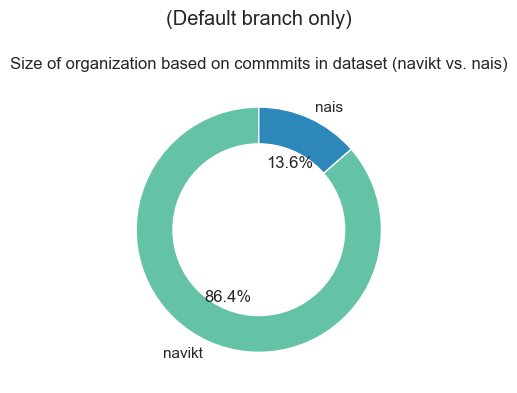

Number of unique commits:  31254
Number of commits from navikt: 27008 (86.41453893901581%)
Number of unique commits from nais: 4246 (13.585461060984194%)
Number of unique repos:  712


In [266]:
# Pie chart for commits and orgs 
df_temp = df.copy()

value_cnts = df_temp["Org"].value_counts()

colors = ["#64C2A6", "#2D87BB"]

sns.set_style("whitegrid") # Set style for chart
plt.figure(figsize=(4,4)) # Set figure size
plt.title("Size of organization based on commmits in dataset (navikt vs. nais)")
plt.suptitle("(Default branch only)")
plt.pie(value_cnts, labels=value_cnts.index, autopct="%1.1f%%", startangle=90, colors=colors)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

num_unique_commits = df_temp["Commit hash"].nunique()
print("Number of unique commits: ", num_unique_commits)

navikt_commits = df_temp[df_temp["Org"] == "navikt"]["Commit hash"].nunique()
print(f"Number of commits from navikt: {navikt_commits} ({(navikt_commits/num_unique_commits)*100}%)")

nais_commits = df_temp[df_temp["Org"] == "nais"]["Commit hash"].nunique()
print(f"Number of unique commits from nais: {nais_commits} ({(nais_commits/num_unique_commits)*100}%)")

num_unique_repos = df_temp["Repository"].nunique()
print("Number of unique repos: ", num_unique_repos)

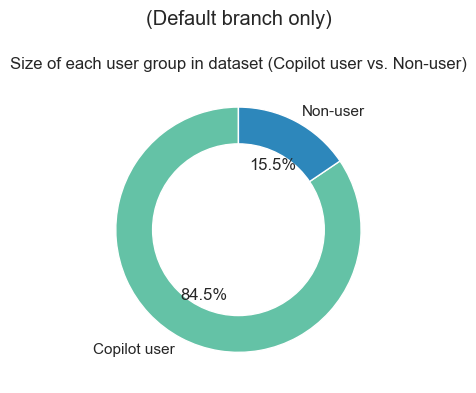

---(Non-merge commits)---
Number of commits (Copilot user):  26400
Number of commits (Non-user):  4854
Number of total commits:  31254
Number of unique users:  40


In [267]:
# Pie chart for user groups
df_temp = df.copy()
df_temp["Copilot user"] = df_temp["Copilot user"].map({True: "Copilot user", False: "Non-user"})

value_cnts = df_temp["Copilot user"].value_counts()

colors = ["#64C2A6", "#2D87BB"]

sns.set_style("whitegrid") # Set style for chart
plt.figure(figsize=(4,4)) # Set figure size
plt.title("Size of each user group in dataset (Copilot user vs. Non-user)")
plt.suptitle("(Default branch only)")
plt.pie(value_cnts, labels=value_cnts.index, autopct="%1.1f%%", startangle=90, colors=colors)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

print("---(Non-merge commits)---")
count_rows_copilot = df_temp[(df_temp["Copilot user"] == "Copilot user")].shape[0]
print("Number of commits (Copilot user): ", count_rows_copilot)

count_rows_nonusers = df_temp[(df_temp["Copilot user"] == "Non-user")].shape[0]
print("Number of commits (Non-user): ", count_rows_nonusers)

total_commits = df_temp.shape[0]
print("Number of total commits: ", total_commits)

num_unique_users= df_temp["User"].nunique()
print("Number of unique users: ", num_unique_users)

/var/folders/r4/f80qwh6n3yx9s80fv586b9xc0000gn/T/ipykernel_6538/1380272355.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


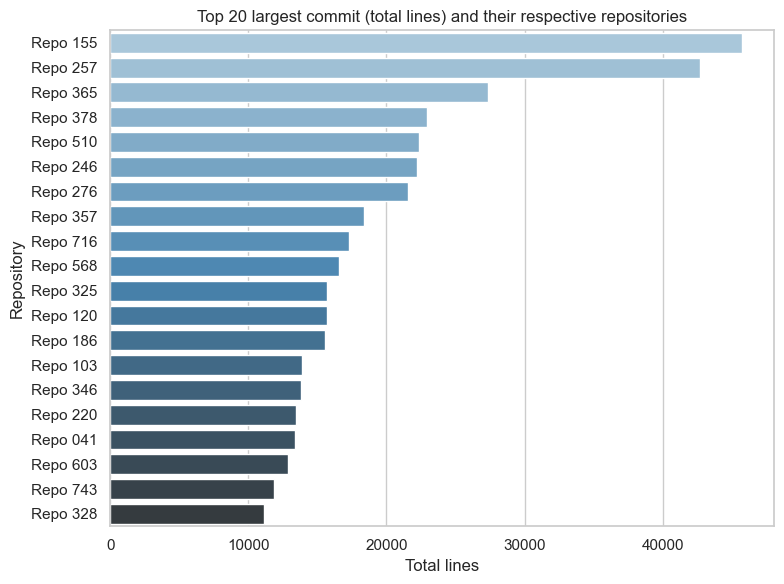

In [268]:
# Plot for top 20 repositories with the largest commits

df_temp = df.copy()
    
top_repos = df_temp.groupby("Repository")["Total lines"].sum().sort_values(ascending=False).head(20).reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_repos,
    x="Total lines",
    y="Repository",
    palette="Blues_d",
    orient="h"
)

plt.xlabel("Total lines")
plt.ylabel("Repository")
plt.title("Top 20 largest commit (total lines) and their respective repositories")
plt.tight_layout()
plt.show()

### Data distributions of the metrics insertions, deletions, total lines, diff, files changed 

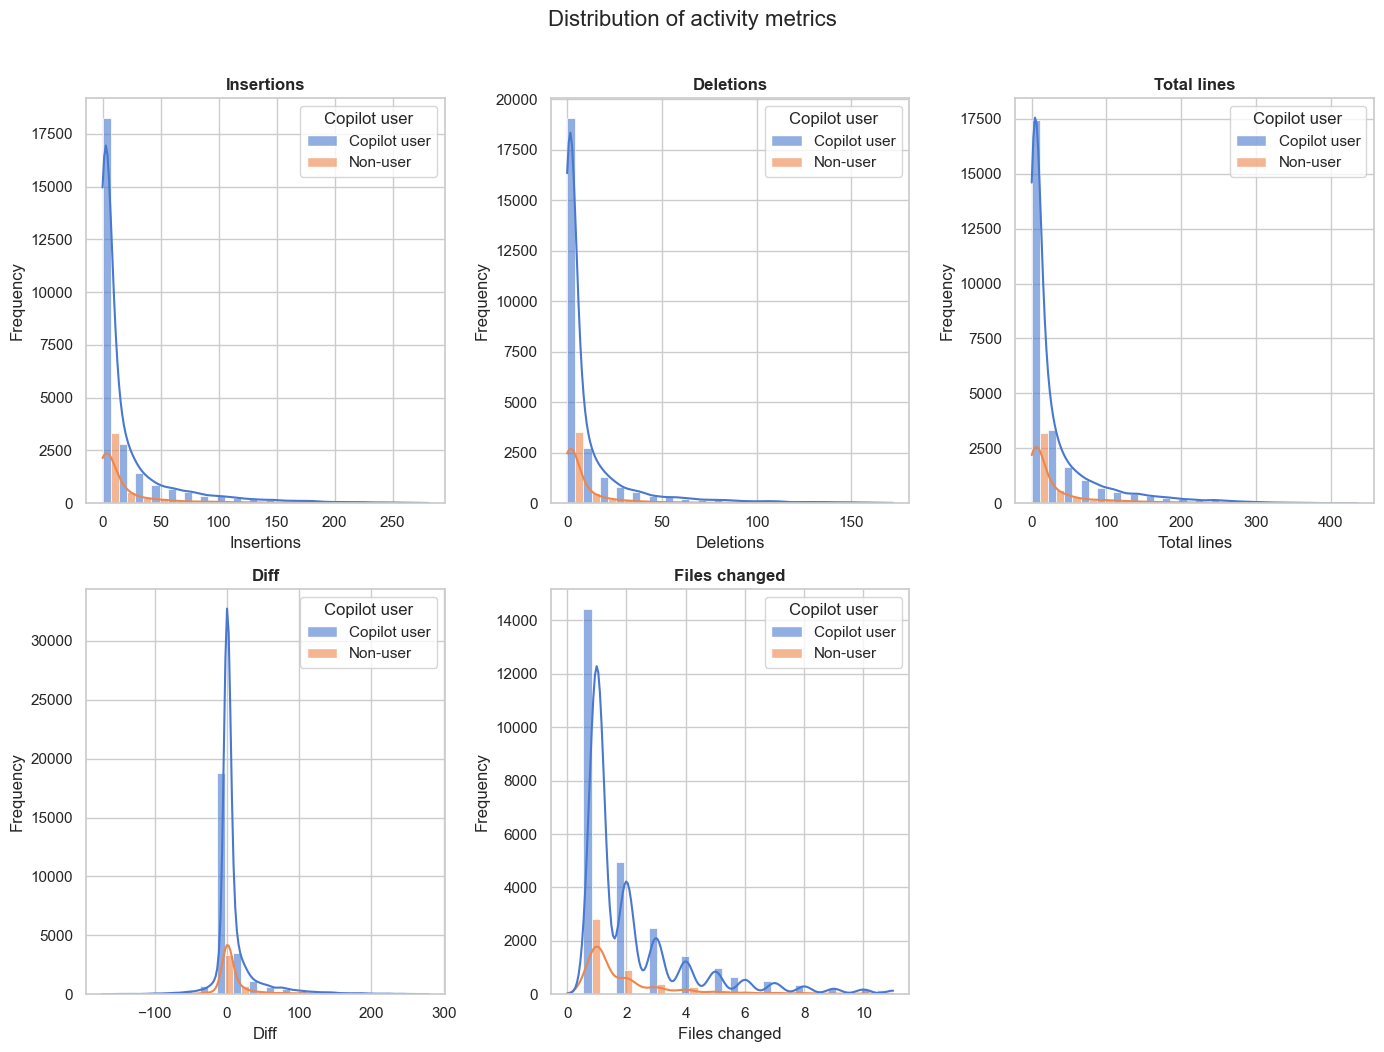

In [269]:
import matplotlib.gridspec as gridspec

# Metrics that we will plot histogram to show data distribution for
metrics = ["Insertions", "Deletions", "Total lines", 
           "Diff", "Files changed"]
# Create grid figure
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(nrows=2, ncols=3, figure=fig)

df_temp = df.copy()
df_temp["Copilot user"] = df_temp["Copilot user"].map({True: "Copilot user", False: "Non-user"})

# Plot each metric
for i, metric in enumerate(metrics):
    g = fig.add_subplot(gs[i])

    sns.histplot(
        data=df_temp,
        x=metric,
        hue="Copilot user",
        kde=True,
        multiple="dodge",
        alpha=0.6,
        bins=20,
        ax=g,
        palette="muted",
        hue_order=["Copilot user", "Non-user"],
    )

    g.set_title(metric, weight="bold")
    g.set_xlabel(f"{metric}")
    g.set_ylabel("Frequency")

plt.tight_layout()
plt.suptitle("Distribution of activity metrics", fontsize=16, y=1.05)


file_name = "histo_data_distribution.pdf"
full_path = os.path.join(plots_parent_dir, file_name)
plt.savefig(full_path, format="pdf")
plt.show()


## Now we calculate the average weekly activity for each user group in each time period (before and after)

In [270]:
# Metrics which we will aggregate 
metrics = ["Insertions", "Deletions", "Total lines", 
           "Diff", "Files changed", "Commits",
           "Unit size (DMM)", "Complexity (DMM)", "Interface (DMM)"]

# Copy original dataframe 
df_temp = df.copy()

num_users = df_temp["User"].nunique()
date_range = f"{df_temp["Date"].min().date()} to {df_temp["Date"].max().date()}"

df_temp = df_temp.set_index("Date")

# Aggregations we will apply to each metric
agg_map = {
    "Insertions": "sum",
    "Deletions": "sum",
    "Total lines": "sum",
    "Diff" : "sum",
    "Files changed": "sum",
    "Commits": "sum",
    "Unit size (DMM)": "mean",
    "Complexity (DMM)": "mean",
    "Interface (DMM)": "mean",
}

# Resample and get weekly activity for each user in each period
user_weekly = (
    df_temp
    .groupby(["User", "Copilot user"])
    .resample("W")
    .agg(agg_map)
    .reset_index()
)

# Sort values based on username and week
user_weekly = user_weekly.sort_values(["User", "Date"])

### What we need to do now is to include all weeks that the user haven't been active in 
Resample fills out the weeks that a user haven't been active in, but only within the timeperiod that the user has been active in. We need to fill out for the whole period (September 1, 2022 to September 1, 2024).  

In [271]:
copilot_users = df[df["Copilot user"] == True]["User"].unique().tolist()
non_users = df[df["Copilot user"] == False]["User"].unique().tolist()

In [272]:
import datetime as dt

# This will create weekly dates for our analysis period, which we will insert for every user
dt_idx = pd.date_range(start="2022-09-01", end="2024-09-01", freq="W")
#print(len(dt_idx))

# Get unique users
users = df["User"].unique()

# Create full cartesian product of all users and dates
full_index = pd.MultiIndex.from_product([users, dt_idx], names=["User", "Date"])

# Create an empty dataframe with the same columns, filled with NaNs
empty_df = pd.DataFrame(index=full_index).reset_index()

# Merge dataframe containing NaNs and dates that will fill out the missing dates that a user haven't been active on
df_user_weekly = pd.merge(
    empty_df,
    user_weekly,
    on=["User", "Date"],
    how="left",
)

df_user_weekly = df_user_weekly.sort_values(by=["User", "Date"])

# Fill NaN values with 0 for the metrics columns, the rest will reamin as NaNs
for metric in ["Insertions", "Deletions", "Total lines", "Diff", "Files changed", "Commits"]:
    df_user_weekly[metric] = df_user_weekly[metric].fillna(0)

COPILOT_PERIOD_START = dt.datetime(2023, 9, 1)

# Assigning correct values to the columns 'Copilot period' and 'Copilot user' that was assigned NaN from the empty_df
df_user_weekly.loc[(df_user_weekly["Date"]) <= COPILOT_PERIOD_START, "Copilot period"] = "before"
df_user_weekly.loc[(df_user_weekly["Date"]) > COPILOT_PERIOD_START, "Copilot period"] = "after"
df_user_weekly.loc[df_user_weekly["User"].isin(copilot_users), "Copilot user"] = True
df_user_weekly.loc[df_user_weekly["User"].isin(non_users), "Copilot user"] = False

df_user_weekly.describe()

,Date,Insertions,Deletions,Total lines,Diff,Files changed,Commits,Unit size (DMM),Complexity (DMM),Interface (DMM)
count,4200,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,1915.000000,1915.000000,1912.000000
mean,2023-09-03 00:00:00,156.807381,84.287381,241.094762,72.520000,16.341429,7.441429,0.527826,0.648037,0.663620
min,2022-09-04 00:00:00,0.000000,0.000000,0.000000,-416.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-03-05 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.500000,0.500000
50%,2023-09-03 00:00:00,32.500000,13.000000,54.000000,2.000000,5.000000,3.000000,0.500000,0.666667,0.666667
75%,2024-03-03 00:00:00,219.000000,113.000000,342.000000,88.000000,22.000000,9.000000,0.735864,1.000000,1.000000
max,2024-09-01 00:00:00,4069.000000,2401.000000,6470.000000,2229.000000,509.000000,259.000000,1.000000,1.000000,1.000000
std,NaN,267.976044,154.532701,406.816960,160.881923,29.835017,14.799603,0.309091,0.310254,0.304986


### Now we check the weekly distrubtion of commits for our users

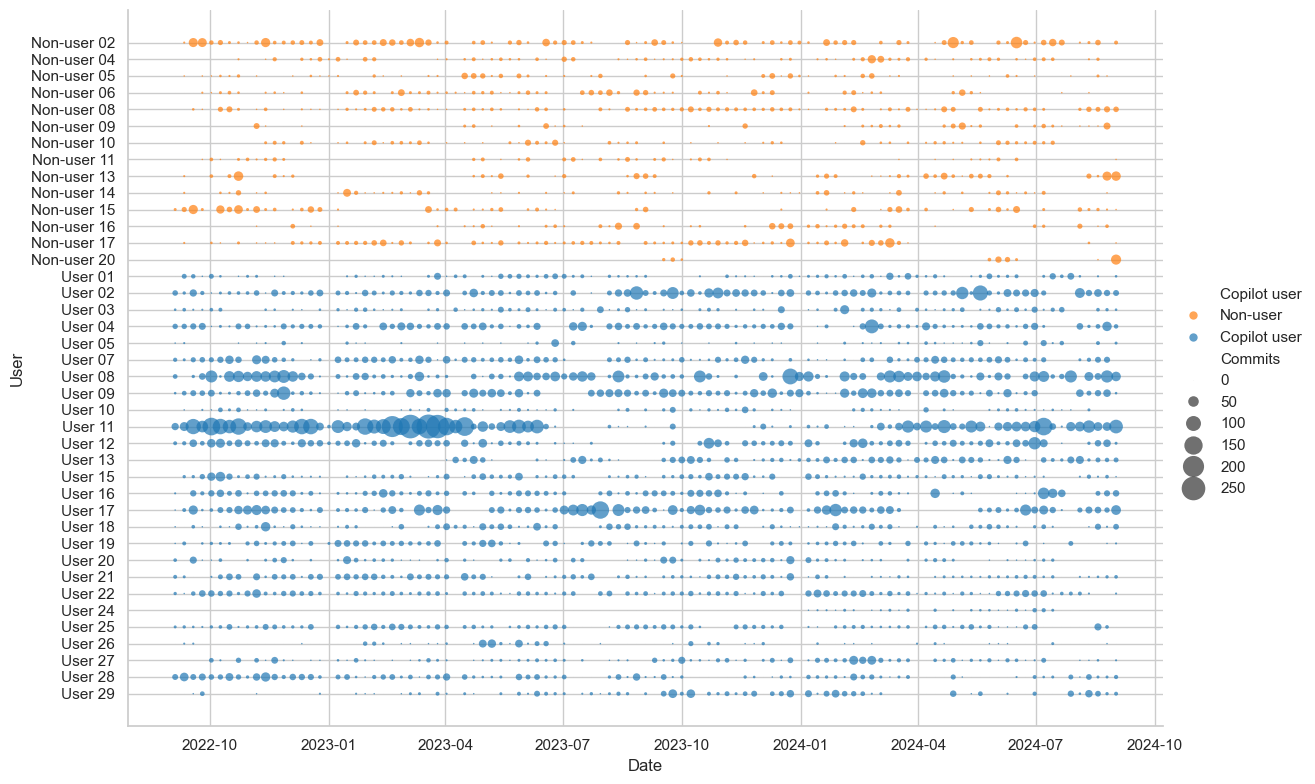

In [273]:
# Set up Seaborn theme
sns.set_theme(style="whitegrid")

df_temp = df_user_weekly.copy()

df_temp["Copilot user"] = df_temp["Copilot user"].map({True: "Copilot user", False: "Non-user"})

palette = ["#ff7f0e", "#1f77b4"] #orange and blue 

# Create the scatter heatmap
g = sns.relplot(
    data=df_temp,
    y="User",
    x="Date",
    hue="Copilot user",
    size="Commits",
    height=8,
    aspect=1.5,
    sizes=(0.01, 300),
    alpha=0.7,
    palette=palette
)

file_name = "scatter_heatmap.pdf"
full_path = os.path.join(plots_parent_dir, file_name)
plt.savefig(full_path, format="pdf")
plt.show()
plt.close()

#### Here we can see that User 11 has a high amount of commits.
- We choose to remove this user due to it being hard to confirm wether all these commits are outliers or not

In [274]:
# Remove user 11
df_user_weekly = df_user_weekly[~df_user_weekly["User"].isin(["User 11"])]
print(f"Number of users after removal: {df_user_weekly["User"].nunique()}")
print(f"Number of commits after user removal: {df_user_weekly["Commits"].sum()}")

Number of users after removal: 39
Number of commits after user removal: 26317.0


### Now we produce some extra plots for the role distribution


{'User 01': ['Utvikler, front-end', 'Utvikler, back-end', 'Tech Lead'], 'User 02': ['Utvikler, front-end', 'Utvikler, back-end'], 'User 03': ['Utvikler, front-end', 'Utvikler, back-end'], 'User 04': ['Platform Engineer'], 'User 05': ['Data Scientist / Analytiker'], 'User 07': ['Utvikler, back-end', 'Platform Engineer'], 'User 08': ['Utvikler, back-end', 'Tech Lead'], 'User 09': ['Utvikler, back-end', 'Tech Lead'], 'User 10': ['Utvikler, back-end', 'Data Engineer'], 'User 12': ['Utvikler, back-end'], 'User 13': ['Utvikler, back-end', 'Tech Lead'], 'User 15': ['Utvikler, front-end', 'Utvikler, back-end'], 'User 16': ['Utvikler, front-end', 'Utvikler, back-end', 'Tech Lead'], 'User 17': ['Platform Engineer'], 'User 18': ['Platform Engineer'], 'User 19': ['Utvikler, front-end'], 'User 20': ['Utvikler, back-end'], 'User 21': ['Utvikler, back-end'], 'User 22': ['Utvikler, front-end', 'Utvikler, back-end'], 'User 24': ['Platform Engineer', 'Data Engineer'], 'User 25': ['Utvikler, front-end']

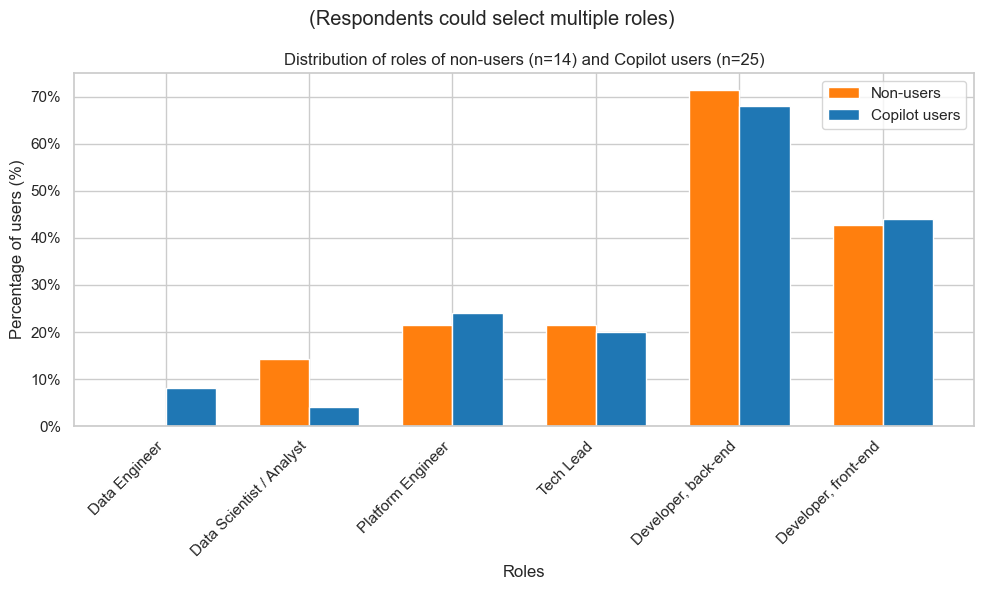

In [275]:
import matplotlib.ticker as ticker


def get_roles(usernames, file_path="./data/survey_data_anonymized_copy.xlsx"):
    """Function to get the developer role for a user

    Args:
        username (str): username for developer
        file_path (str, optional): filepath to sruvey data. Defaults to "./data/survey_data_anonymized_copy.xlsx".

    Returns:
        dictionary: key is username and value is the role of the user
    """
    # Read the excel fil with the labels sheet, only use columns from survey that had questions about roles, and the column for usernames
    df = pd.read_excel(file_path, sheet_name="Labels", usecols="G:P,DI")
    
    username_col = "GitHub-metrikker : GitHub-brukernavn (valgfritt):"
    df[username_col] = df[username_col].astype(str).str.strip()
    
    result = {}
    for username in usernames:
        username = username.strip()
    
        df_user = df[df[username_col] == username]
        
        role_answers = df_user.drop(columns=["GitHub-metrikker : GitHub-brukernavn (valgfritt):"])
    
        roles = []
        for col in role_answers.columns:
            value = df_user.iloc[0][col]
            if (pd.notna(value) and str(value).strip()):
                
                # Skip if role is "Security champion" or "Annet, vennligst spesifier" due to only one user choosing this along with other roles
                if("security champion" in str(value).strip()):
                    continue
                if("Annet, vennligst spesifiser" in str(value).strip()):
                    continue
                
                roles.append(str(value).strip())
                
                
        result[username] = roles
    
    print(f"\n{result}")
    return result


def replace_labels(labels):
    """Replaces labels of roles form the survey. Essentially translates
    Norwegian role names to English. 

    Args:
        labels (lst): list of labels

    Returns:
        lst: list of labels that have the correct raplaced label
    """
    updatet_roles = []
    for role in labels:
        if("Utvikler," in role):
            role = role.replace("Utvikler","Developer")
        
        if("Analytiker" in role):
            role = role.replace("Analytiker","Analyst")
            
        updatet_roles.append(role)
    return updatet_roles


# Create plot
df_temp = df_user_weekly.copy()

df_copilot = df_temp[df_temp["Copilot user"] == True]
df_nonusers = df_temp[df_temp["Copilot user"] == False]

copilot_users = df_copilot["User"].unique().tolist()
nonusers = df_nonusers["User"].unique().tolist()

copilot_roles = get_roles(copilot_users)
nonusers_roles = get_roles(nonusers)

# Get total number of users in each group
total_copilot_users = len(copilot_users)
total_nonusers = len(nonusers)

nonusers_value_cnts = {}
for username, roles in nonusers_roles.items():
    for role in roles:
        if(role in nonusers_value_cnts):
            nonusers_value_cnts[role] += 1
        else:
            nonusers_value_cnts[role] = 1
        

copilot_value_cnts = {}
for username, roles in copilot_roles.items():
    for role in roles:
        if(role in copilot_value_cnts):
            copilot_value_cnts[role] += 1
        else:
            copilot_value_cnts[role] = 1

all_roles = sorted(set(copilot_value_cnts.keys()).union(nonusers_value_cnts.keys()))
updated_role_labels = replace_labels(all_roles)

# Calculate percentages instead of counts
copilot_percentages = [(copilot_value_cnts.get(role, 0) / total_copilot_users * 100) for role in all_roles]
nonuser_percentages = [(nonusers_value_cnts.get(role, 0) / total_nonusers * 100) for role in all_roles]

print(copilot_percentages)
print(nonuser_percentages)

# Plot grouped bar chart with percentages
x = np.arange(len(updated_role_labels))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, nonuser_percentages, width, label="Non-users", color="#ff7f0e")
plt.bar(x + width/2, copilot_percentages, width, label="Copilot users", color="#1f77b4")
plt.xticks(x, updated_role_labels, rotation=45, ha='right')
plt.xlabel("Roles")
plt.ylabel("Percentage of users (%)")
plt.title(f"Distribution of roles of non-users (n={total_nonusers}) and Copilot users (n={total_copilot_users})")
plt.suptitle("(Respondents could select multiple roles)")
plt.legend()

# Set y-axis to show percentage formatting
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

plt.tight_layout()
file_name = "all_roles.pdf"
full_path = os.path.join(plots_parent_dir, file_name)
plt.savefig(full_path, format="pdf")
plt.show()
plt.close()


# This part gets some descriptive statistics for each user group 
- The data gets exported to a latex file

### Weekly activity (2022-09-01 to 2024-09-01) - Non-users

In [276]:
df_user_weekly[df_user_weekly["Copilot user"] == False].drop(columns=["Date"]).describe()

,Insertions,Deletions,Total lines,Diff,Files changed,Commits,Unit size (DMM),Complexity (DMM),Interface (DMM)
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,385.000000,384.000000,384.000000
mean,70.576871,35.822449,106.399320,34.754422,6.901361,3.302041,0.551713,0.646440,0.646681
std,149.704026,79.074896,217.943655,99.140466,12.942211,6.128747,0.327549,0.332272,0.331819
min,0.000000,0.000000,0.000000,-416.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.500000,0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.527778,0.666667,0.666667
75%,78.500000,31.000000,127.750000,23.750000,9.000000,4.000000,0.833333,1.000000,1.000000
max,1470.000000,854.000000,2150.000000,913.000000,123.000000,60.000000,1.000000,1.000000,1.000000


In [277]:
latex_nonusers = df_user_weekly[df_user_weekly["Copilot user"] == False].drop(columns=["Date"]).describe().T.to_latex(
    caption="Weekly activity of Non-users.", 
    label="tab:weekly_act_nonusers", 
    index=True,
    float_format="%.2f")

with open("non_users_summary.tex", "w") as f:
    f.write(latex_nonusers)

### Weekly activity (2022-09-01 to 2024-09-01) - Copilot users

In [278]:
df_user_weekly[df_user_weekly["Copilot user"] == True].drop(columns=["Date"]).describe()

,Insertions,Deletions,Total lines,Diff,Files changed,Commits,Unit size (DMM),Complexity (DMM),Interface (DMM)
count,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,1454.000000,1455.000000,1452.000000
mean,194.189714,101.391619,295.581333,92.798095,18.845333,8.176381,0.519676,0.651354,0.671958
std,290.452414,157.362933,429.713954,183.295700,25.505194,11.468098,0.308147,0.308261,0.301705
min,0.000000,0.000000,0.000000,-375.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.500000,0.500000
50%,86.000000,35.000000,137.000000,13.000000,9.000000,4.000000,0.500000,0.666667,0.673356
75%,278.000000,147.000000,435.000000,130.000000,28.000000,11.000000,0.717842,1.000000,1.000000
max,4069.000000,2401.000000,6470.000000,2229.000000,269.000000,136.000000,1.000000,1.000000,1.000000


In [279]:
latex_copilot = df_user_weekly[df_user_weekly["Copilot user"] == True].drop(columns=["Date"]).describe().T.to_latex(
    caption="Weekly activity of Copilot users.", 
    label="tab:weekly_act_copilot", 
    index=True, 
    float_format="%.2f")

with open("copilot_users_summary.tex", "w") as f:
    f.write(latex_copilot)

# Creating plots for weekly activity

We will now create several plots to analyze the different activity levels. The following analytical scenarios will be performed:

1. Differences in activity between Copilot users and Non-users -
Addressing RQ1 and RQ2:
- Aggregate the average weekly activity of Copilot and Non-users in the 2022-
09-01 to 2024-09-01, across several metrics such as insertions, deletions, and
commit frequency.
- Evaluate the overall activity trend across both groups before and after Copilot
introduction

2. Correlation of activity metrics as A-dimension variables in the SPACE
Framework and their relationship to perceived productivity (Copilot
users only) - Addressing RQ3:
- Analyze how different activity metrics (e.g., insertions, deletions, commits,
etc.) correlate with each other to evaluate their suitability as variables of the
Activity (A) dimension in the SPACE framework.
- Examine the relationship between individual activity metrics and changes in
perceived productivity, based on Copilot usage.

## 1. Differences in activity between Copilot users and Non-users

###  Line plots - Showing weekly trend of activity metrics from September 1, 2022 to September 1, 2024 - Copilot users vs. Non-users 

In [280]:
# Directory for lineplots
parent_dir = plots_parent_dir
line_plots_sub_dir = "line_plots"
line_plots_path = os.path.join(parent_dir, line_plots_sub_dir)
os.makedirs(line_plots_path, exist_ok=True)

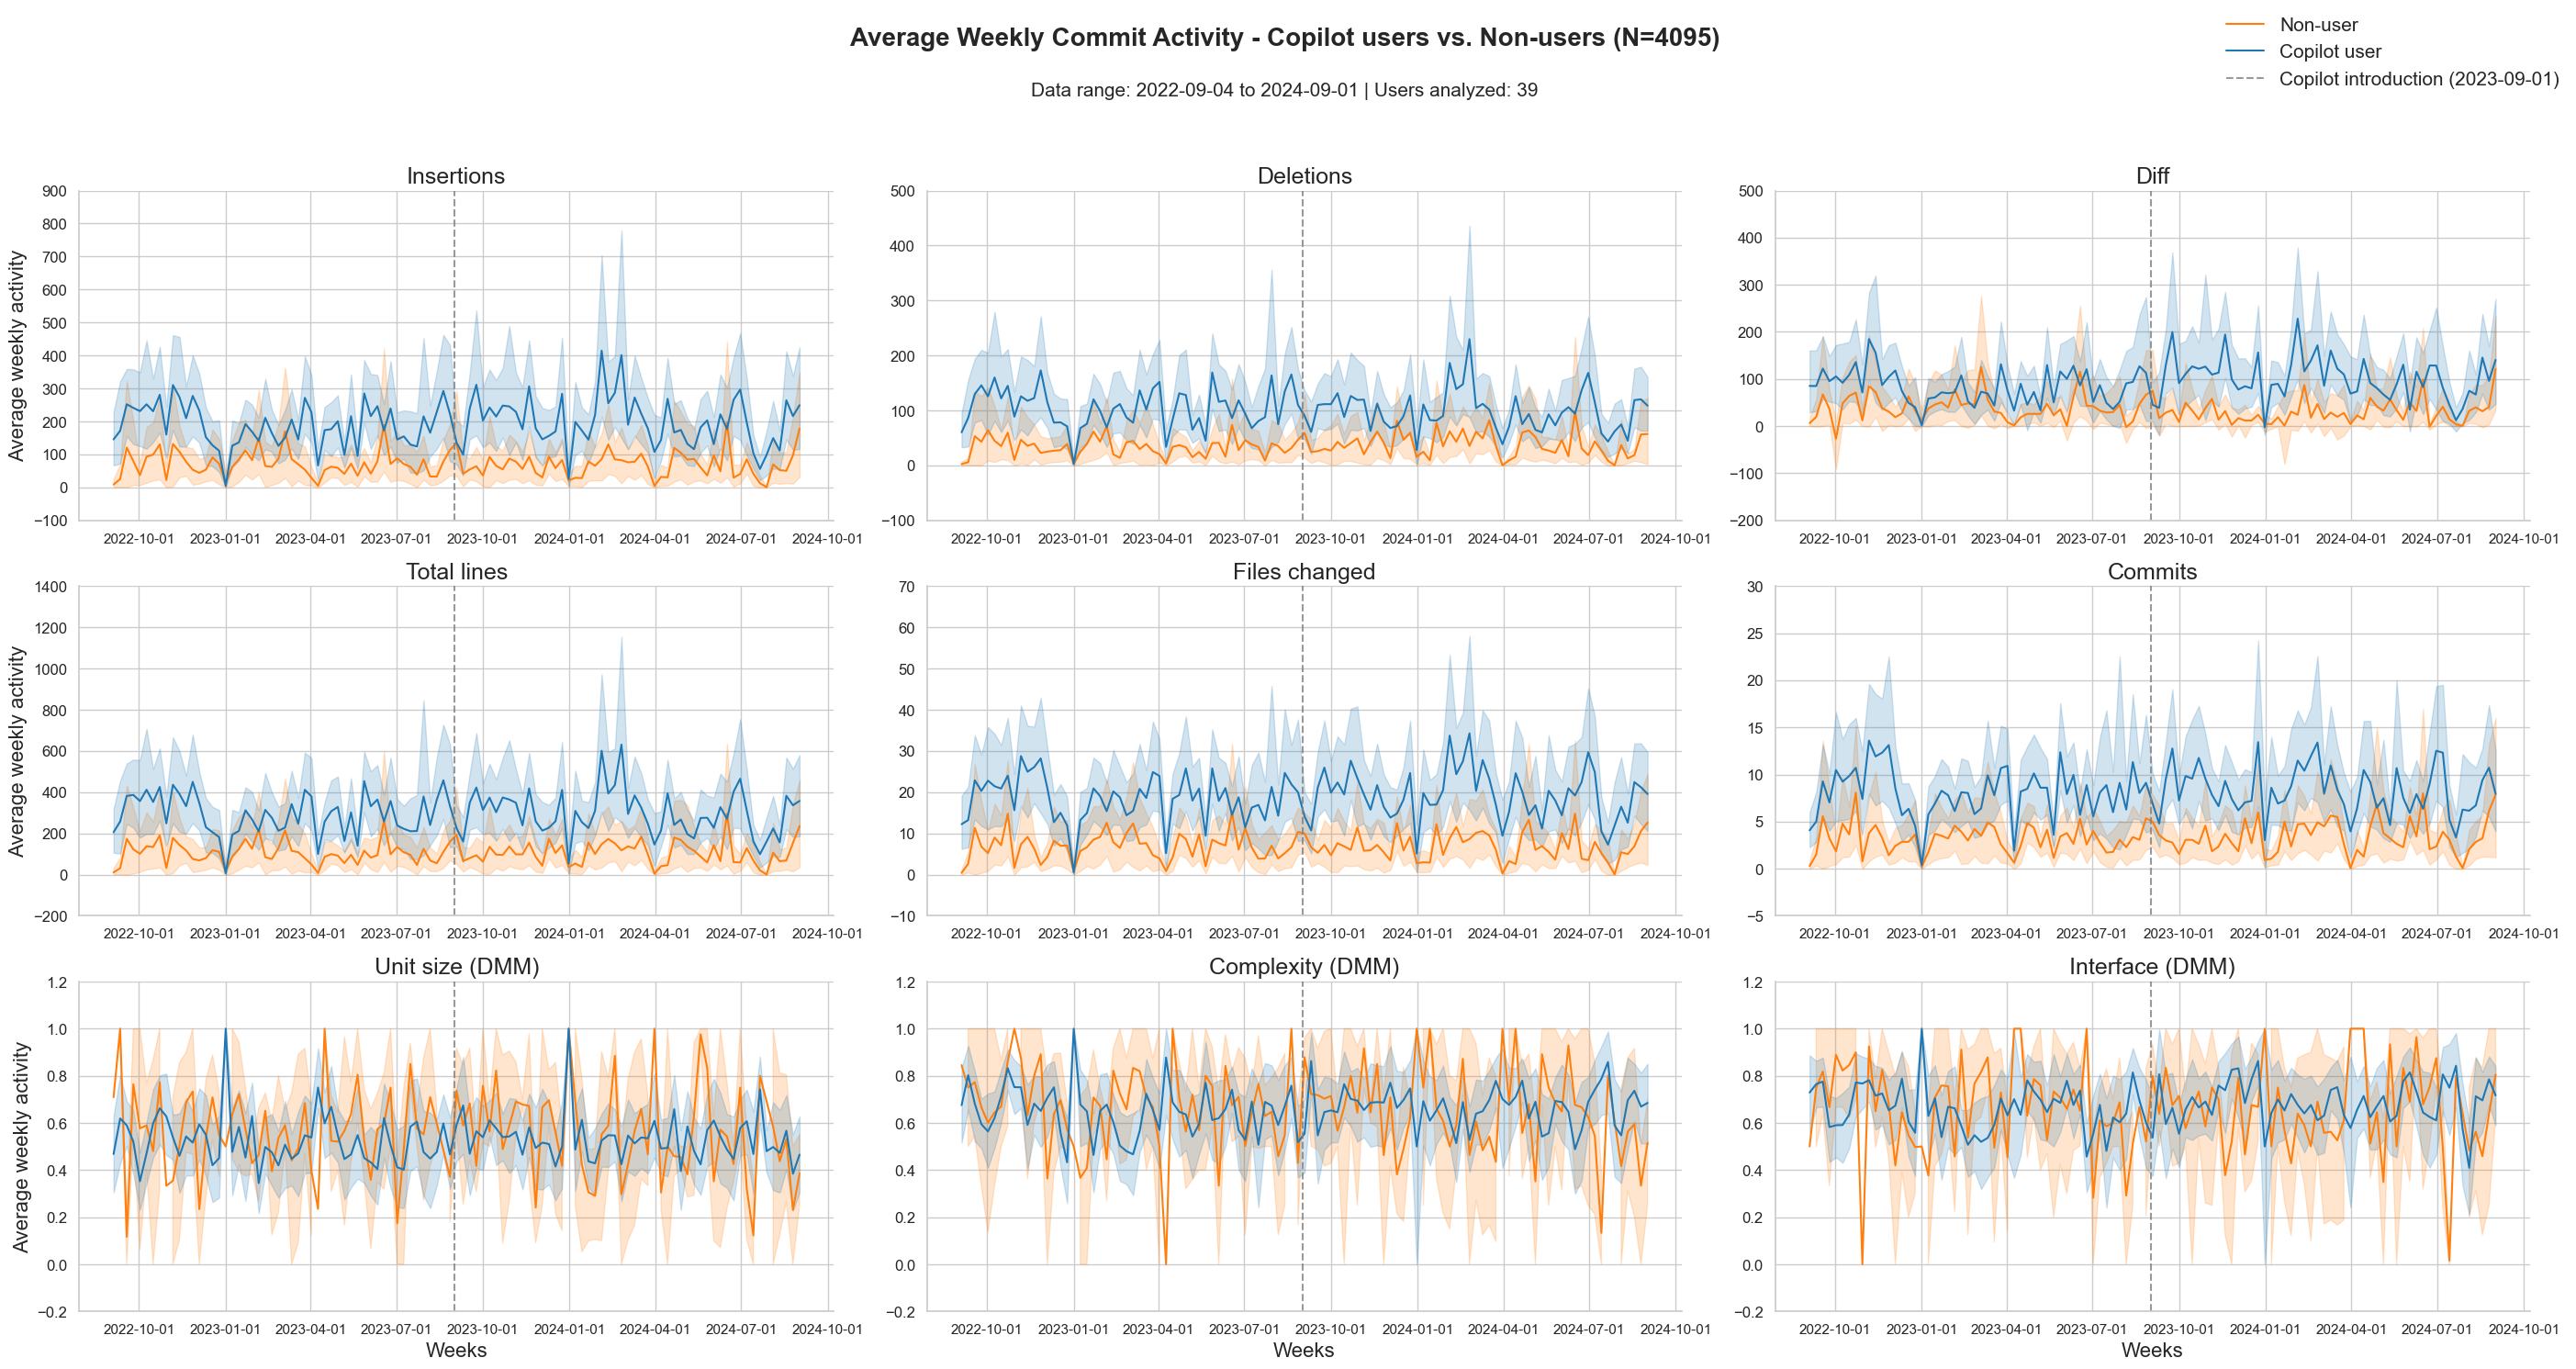

In [281]:
# Metrics which we will aggregate 
metrics = ["Insertions", "Deletions", "Diff", 
           "Total lines", "Files changed", "Commits",
           "Unit size (DMM)", "Complexity (DMM)", "Interface (DMM)"]

# Remap the copilot user column values so it's more readable
df_temp = df_user_weekly.copy()
df_temp["Copilot user"] = df_temp["Copilot user"].map({True: "Copilot user", False: "Non-user"})
df_temp = df_temp.rename(columns={"Date": "Week"})

# Info for chart
num_users = df_temp["User"].nunique()
date_range = f"{df_temp["Week"].min().date()} to {df_temp["Week"].max().date()}"

# Melt the dataframe so it"s easier to work with when plotting multiple bar plots
df_melted = df_temp.melt(
    id_vars=["Week", "Copilot user", "User"],
    value_vars=metrics,
    var_name="Metric",
    value_name="Value"
)

palette = [ "#ff7f0e", "#1f77b4"] #orange and blue 

g = sns.relplot(
    data=df_melted,
    x="Week", 
    y="Value",
    hue="Copilot user", 
    col="Metric",
    aspect=1.6, 
    kind="line",
    estimator=np.mean,
    errorbar=("ci", 95),
    palette=palette,
    col_wrap=3,
    facet_kws={"sharey": False, "sharex": False},
)

g.refline(x=pd.Timestamp("2023-09-01"), color="gray", linestyle="--", alpha=0.8, label="Copilot introduction (2023-09-01)")
g._legend.remove()
g.add_legend()
sns.move_legend(g, "upper right", fontsize=15)

# Configurations
g.figure.subplots_adjust(top=0.9, hspace=0.4, wspace=0.1)
g.set_xlabels("Weeks", size=16)
g.set_xticklabels(size=11)
g.set_yticklabels(size=12)
g.set_ylabels("Average weekly activity", size=16)
g.set_titles(col_template="{col_name}", size=18)
g.figure.suptitle(f"Average Weekly Commit Activity - Copilot users vs. Non-users (N={df_temp.shape[0]})", weight="bold", fontsize=20)
g.figure.text(0.5, 0.93, f"Data range: {date_range} | Users analyzed: {num_users}", fontsize=15, ha="center")
    
plt.tight_layout(rect=[0, 0, 1, 0.92])
file_name = f"lineplot_copilot_nonusers.pdf"
full_path = os.path.join(line_plots_path, file_name)
plt.savefig(full_path, format="pdf")
plt.show()
plt.close()

### Generating and saving individual lineplots

In [282]:
# Metrics which we will aggregate 
metrics = ["Insertions", "Deletions", "Diff", 
           "Total lines", "Files changed", "Commits",
           "Unit size (DMM)", "Complexity (DMM)", "Interface (DMM)"]

for metric in metrics:

    # Remap the copilot user column values so it's more readable
    df_temp = df_user_weekly.copy()
    df_temp["Copilot user"] = df_temp["Copilot user"].map({True: "Copilot user", False: "Non-user"})
    df_temp = df_temp.rename(columns={"Date": "Week"})

    # Info for chart
    num_users = df_temp["User"].nunique()
    date_range = f"{df_temp["Week"].min().date()} to {df_temp["Week"].max().date()}"

    # Melt the dataframe so it"s easier to work with when plotting multiple bar plots
    df_melted = df_temp.melt(
        id_vars=["Week", "Copilot user", "User"],
        value_vars=metric,
        var_name="Metric",
        value_name="Value"
    )

    palette = ["#ff7f0e", "#1f77b4"] #orange and blue 
    plt.figure(figsize=(14, 7))

    ax = sns.lineplot(
        data=df_melted,
        x="Week", 
        y="Value",
        hue="Copilot user", 
        estimator=np.mean,
        errorbar=("ci", 95),
        palette=palette,
    )

    # Add vertical line for cCopilot introduction
    ax.axvline(x=pd.Timestamp("2023-09-01"), color="red", linestyle="--", alpha=0.8, label="Copilot introduction (2023-09-01)")

    # Configurations
    ax.set_xlabel("Weeks", fontsize=16)
    ax.set_ylabel(f"Average weekly {metric}", fontsize=16)
    ax.set_title(f"{metric} - Non-users vs. Copilot users\n(N={df_temp.shape[0]})", fontsize=18, weight="bold")
    plt.suptitle(f"Data range: {date_range} | Users analyzed: {num_users}", fontsize=12, y=0.92)
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc="upper right", fontsize=11)
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    
    file_name = f"{metric}_lineplot_copilot_nonusers.pdf"
    full_path = os.path.join(line_plots_path, file_name)
    
    plt.savefig(full_path, format="pdf")
    print(f"All lineplots saved sucessfully to {line_plots_path}!")
    plt.close()

All lineplots saved sucessfully to plots/line_plots!
All lineplots saved sucessfully to plots/line_plots!
All lineplots saved sucessfully to plots/line_plots!
All lineplots saved sucessfully to plots/line_plots!
All lineplots saved sucessfully to plots/line_plots!
All lineplots saved sucessfully to plots/line_plots!
All lineplots saved sucessfully to plots/line_plots!
All lineplots saved sucessfully to plots/line_plots!
All lineplots saved sucessfully to plots/line_plots!


## Aggregated analysis
- Generate bar plots to analyze Copilot users and non-users
- Before and after introduction of GitHub Copilot in NAV (September 1, 2023)

In [283]:
# Directory for barplots
parent_dir = plots_parent_dir
bar_plots_sub_dir = "bar_plots"
bar_plots_path = os.path.join(parent_dir, bar_plots_sub_dir)
os.makedirs(bar_plots_path, exist_ok=True)

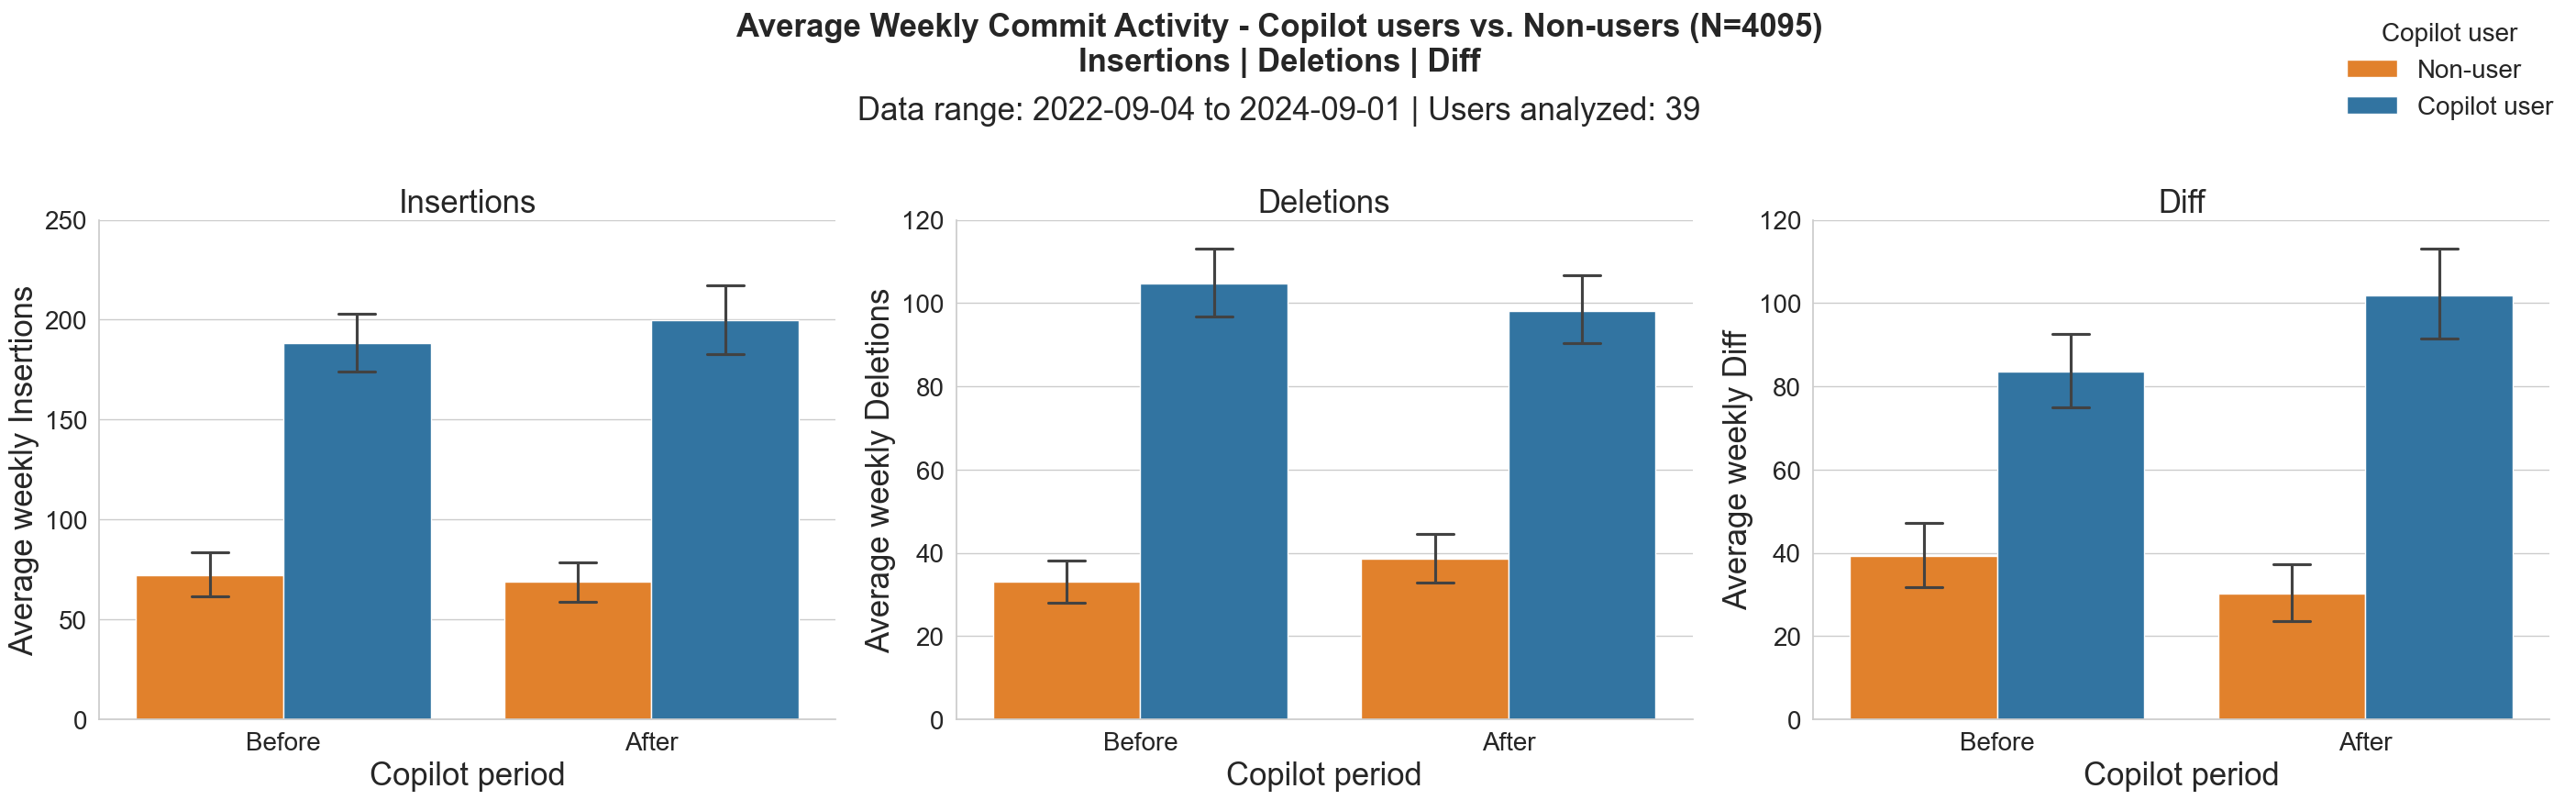

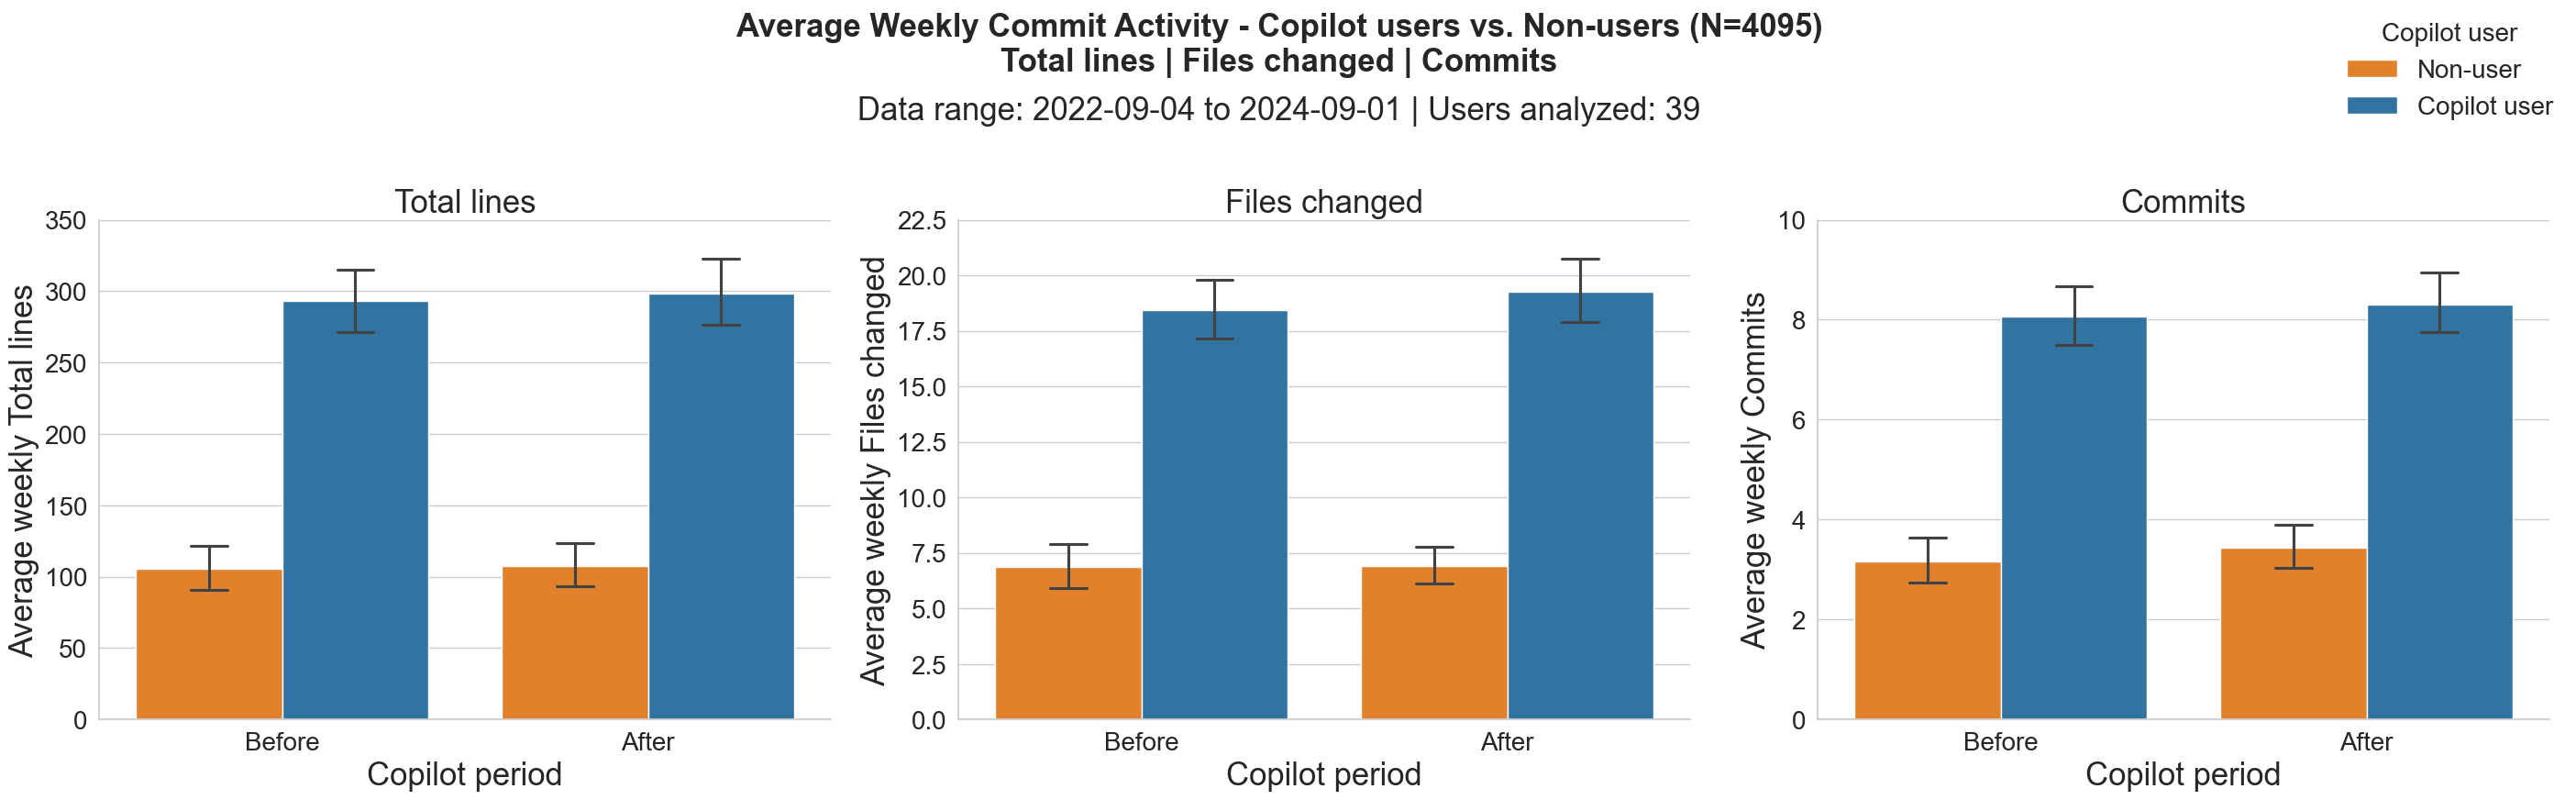

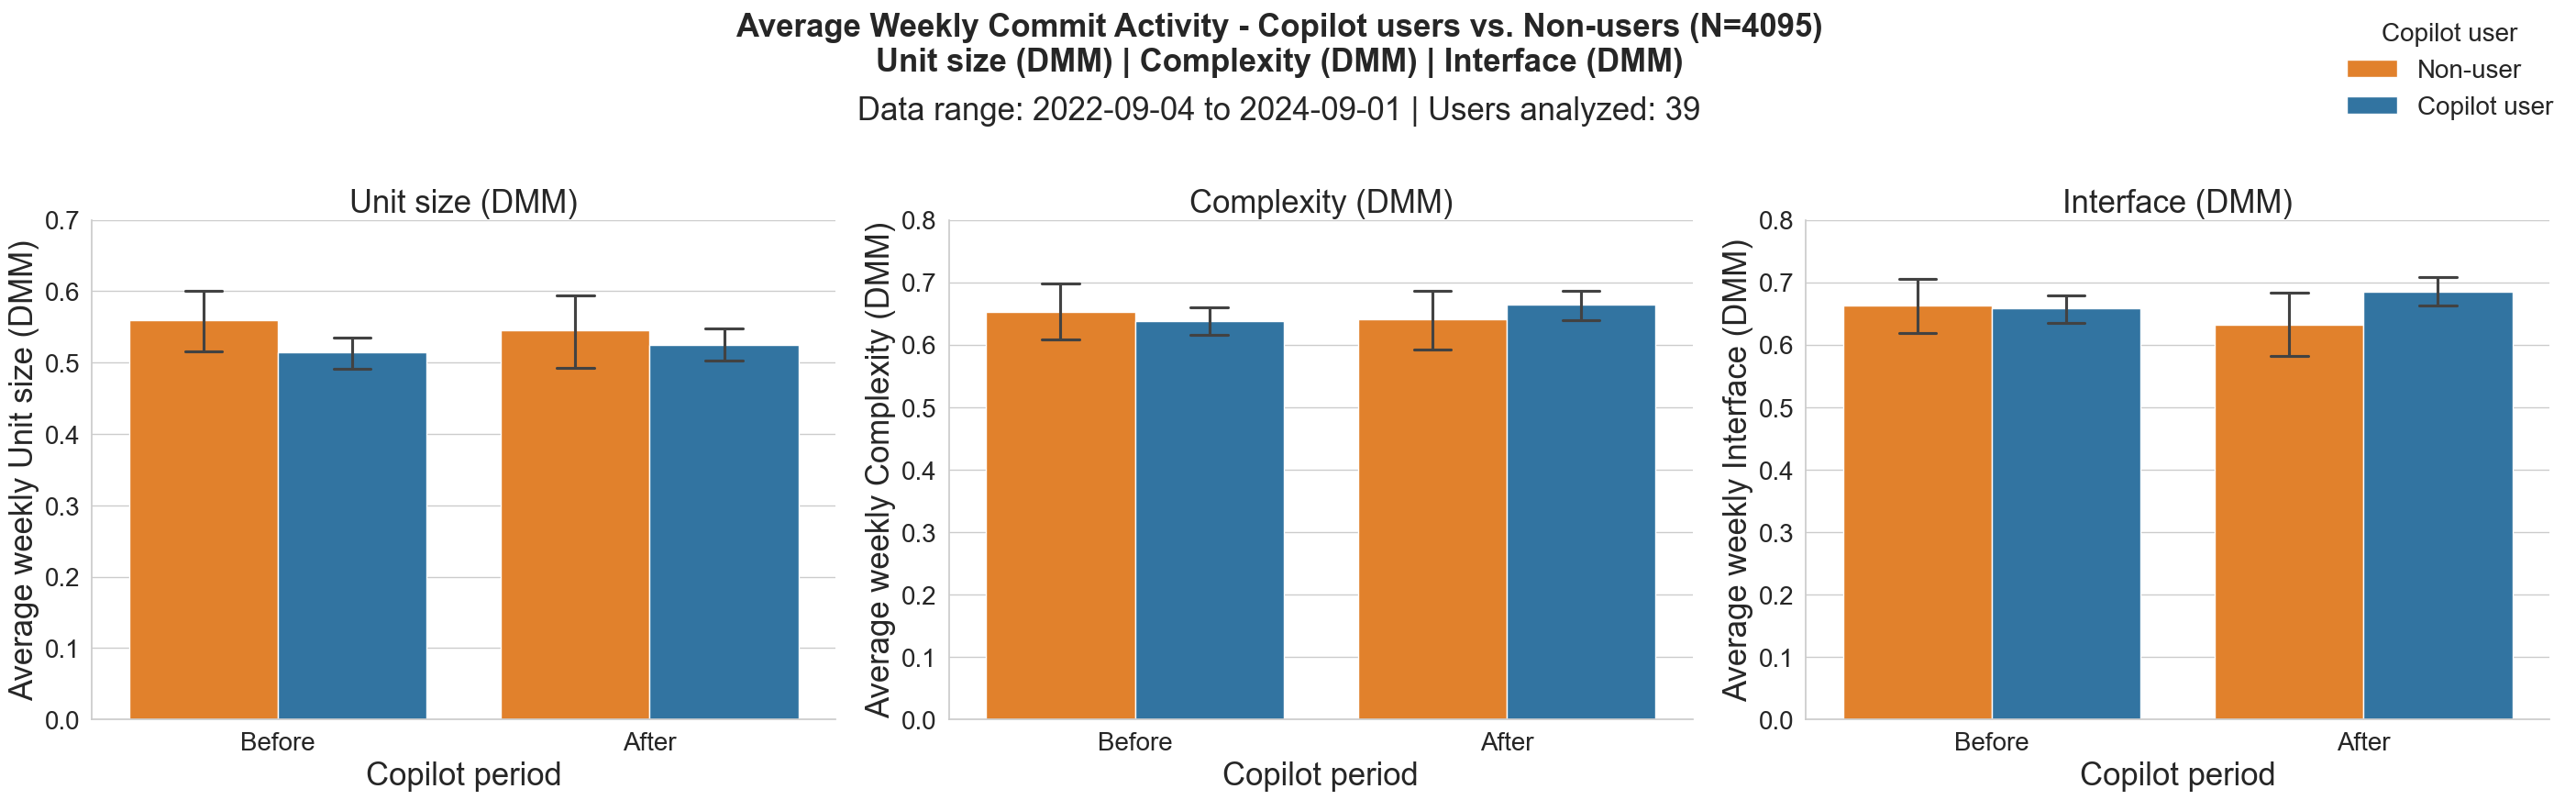

Grouped bar plots saved sucessfully to plots/bar_plots


In [284]:
metric_groups = [["Insertions", "Deletions", "Diff"], 
           ["Total lines", "Files changed", "Commits"], 
           ["Unit size (DMM)", "Complexity (DMM)", "Interface (DMM)"]]

df_temp = df_user_weekly.copy()
df_temp["Copilot user"] = df_temp["Copilot user"].map({True: "Copilot user", False: "Non-user"})
df_temp["Copilot period"] = df_temp["Copilot period"].map({"before": "Before", "after": "After"})
#df_temp["Copilot period"] = df_temp["Copilot period"].map({"before": "Before", "after": "After"})

df_temp = df_temp.rename(columns={"Date": "Week"})

# Info for chart
num_users = df_temp["User"].nunique()
date_range = f"{df_temp["Week"].min().date()} to {df_temp["Week"].max().date()}"

for i, metric_group in enumerate(metric_groups):

    # Melt the dataframe so it"s easier to work with when plotting multiple bar plots
    df_melted = df_temp.melt(
        id_vars=["Week", "Copilot user", "User", "Copilot period"],
        value_vars=metric_group,
        var_name="Metric",
        value_name="Value"
    )

    palette = ["#ff7f0e", "#1f77b4"] #orange and blue 

    # Plot categorical plot 
    g = sns.catplot(
        data=df_melted, 
        x="Copilot period", 
        y="Value", 
        hue="Copilot user",
        kind="bar", 
        estimator=np.mean,
        col="Metric",
        sharey=False,
        sharex=False,
        errorbar=("ci", 95),
        col_wrap=3,
        order=["Before", "After"],
        hue_order=["Non-user", "Copilot user"],
        palette=palette,
        height=9,
        #aspect=1.2,
        capsize=0.2,
    )

    # Configurations
    g.figure.subplots_adjust(hspace=0.4, wspace=0.3)
    g.set_xlabels(size=25)
    #g.set_ylabels(size=18)
    g.set_xticklabels(size=20)
    g.set_yticklabels(size=20)

    g.set_titles(col_template="{col_name}", size=25)
    
    metric_names = " | ".join(metric_group)
    g.figure.suptitle(f"Average Weekly Commit Activity - Copilot users vs. Non-users (N={df_temp.shape[0]})\n{metric_names}", 
                      weight="bold", fontsize=25)
    g.figure.text(0.5, 0.85, f"Data range: {date_range} | Users analyzed: {num_users}", fontsize=25, ha="center")

    # Loop over axes for custom y-labels and titles
    for a in g.axes.flat:
        title = a.get_title()
        metric = title.split('=')[-1].strip()
        a.set_ylabel(f"Average weekly {metric}", size=25)
    

    sns.move_legend(g, "upper right", fontsize=20)
    g._legend.set_title("Copilot user", prop={'size': 20})
    plt.tight_layout(rect=[0, 0, 1, 0.92], pad=2)
    
    file_name = f"group{i+1}_barplot_copilot_nonusers.pdf"
    full_path = os.path.join(bar_plots_path, file_name)
    plt.savefig(full_path, format="pdf")
    plt.show()

print(f"Grouped bar plots saved sucessfully to {bar_plots_path}")

## Statistical significance tests
We will now perform two kinds of statistical tests:

1. Wilcoxon test to test statistical significance of activity levels in each period (before and after)
- Used to check for significant differences in activity levels for e.g., after adopting Copilot

2. Mann-Whitney U tests to test statistical significance of activity levels between the two groups in each period
- Used to check if there is a significant difference in activity levels to check, e.g. wether Copilot users are more active than the non-users in the "after" period.

### 1. Wilcoxon test

In [285]:
from scipy.stats import wilcoxon

def test_wilcoxon(df, metric, user_group):
    """Wilcoxon test to perform statisical significance test
    on "before-and-after" of two related samples from one
    independent group.

    Args:
        df (DataFrame): DataFrame containing users average weekly activity for the metric 
        metric (str): Str of metric that will be used to index DataFrame
        user_group (str): Str of user group we wish to analyze, is indexed in dataframe

    Returns:
        tuple: (stat, p-value)
    """
    df_temp = df.copy()
    df_temp = df_temp.set_index("Date")
    
    print(f"\nNumber of commits before filtering: {df_temp.shape[0]}")

    # Filter out merge commits and only copilot users (since we are looking at before and after implementation)
    if(user_group == "copilot"):
        df_temp = df_temp[(df_temp["Copilot user"] == True)]
    else:
        df_temp = df_temp[(df_temp["Copilot user"] == False)]

    print(f"Number of commits analyzed (after filtering): {df_temp.shape[0]}")

    # Group by user and for each period to get their average weekly activity levels for each period
    df_temp = df_temp.groupby(["User", "Copilot period"])[metric].mean().reset_index()
    df_pivot = df_temp.pivot(index="User", columns="Copilot period", values=metric)
    df_pivot = df_pivot.dropna(subset=["before", "after"])

    # Perform Wilcoxon Signed-Rank Test
    stat, p_value = wilcoxon(df_pivot["before"], df_pivot["after"])

    print(f"\nWilcoxon Signed-Rank Test for number of {metric}")
    print(f"Statistic: {stat:.4f}")
    print(f"P-value:   {p_value:.4f}")

    # Threshold for significance 
    alpha = 0.00555 #0.00833 # 0.005555555556
    if p_value < alpha:
        print(f"Statistically significant difference between periods (p < {alpha})")
    else:
        print(f"NO statistically significant difference (p ≥ {alpha})")
        
    return stat, p_value

### Printing out the results of the wilcoxon test
- First check the differences in before-and-after of the Copilot users

In [286]:
metrics = ["Insertions", "Deletions", "Diff", "Total lines", "Files changed", "Commits", "Unit size (DMM)", "Complexity (DMM)", "Interface (DMM)"]

for metric in metrics:
    print("_"*80)
    test_wilcoxon(df_user_weekly, metric, "copilot")

________________________________________________________________________________

Number of commits before filtering: 4095
Number of commits analyzed (after filtering): 2625

Wilcoxon Signed-Rank Test for number of Insertions
Statistic: 147.0000
P-value:   0.6915
NO statistically significant difference (p ≥ 0.00555)
________________________________________________________________________________

Number of commits before filtering: 4095
Number of commits analyzed (after filtering): 2625

Wilcoxon Signed-Rank Test for number of Deletions
Statistic: 150.0000
P-value:   0.7510
NO statistically significant difference (p ≥ 0.00555)
________________________________________________________________________________

Number of commits before filtering: 4095
Number of commits analyzed (after filtering): 2625

Wilcoxon Signed-Rank Test for number of Diff
Statistic: 110.0000
P-value:   0.1645
NO statistically significant difference (p ≥ 0.00555)
_____________________________________________________

- Then the same for non-users

In [287]:
for metric in metrics:
    print("_"*80)
    test_wilcoxon(df_user_weekly, metric, "non-user")

________________________________________________________________________________

Number of commits before filtering: 4095
Number of commits analyzed (after filtering): 1470

Wilcoxon Signed-Rank Test for number of Insertions
Statistic: 49.0000
P-value:   0.8552
NO statistically significant difference (p ≥ 0.00555)
________________________________________________________________________________

Number of commits before filtering: 4095
Number of commits analyzed (after filtering): 1470

Wilcoxon Signed-Rank Test for number of Deletions
Statistic: 35.0000
P-value:   0.2958
NO statistically significant difference (p ≥ 0.00555)
________________________________________________________________________________

Number of commits before filtering: 4095
Number of commits analyzed (after filtering): 1470

Wilcoxon Signed-Rank Test for number of Diff
Statistic: 31.0000
P-value:   0.1937
NO statistically significant difference (p ≥ 0.00555)
________________________________________________________

### 2. Mann-Whitney U test

In [288]:
from scipy.stats import mannwhitneyu

def test_mannwhitneyu(df, metric, period):
    """Comparing before vs. after 
    
    Args:
        df (DataFrame): DataFrame containing users average weekly activity for the metric 
        metric (str): Str of metric that will be used to index DataFrame
        period (str): Str of what period we are comparing the two groups for

    Returns:
        tuple: (stat, p-value)
    """
    df_temp = df.copy()
    print(f"\nNumber of commits before filtering: {df_temp.shape[0]}")

    df_temp = df_temp[(df_temp["Copilot period"] == period)]
    
    print(f"Number of commits analyzed (after filtering): {df_temp.shape[0]}")
    
    # Get the average weekly mean for each user in each epriod
    user_agg = df_temp.groupby(["User", "Copilot user"])[metric].mean().reset_index()
    
    # Seperate the results into each user group as we are comparing the metrics between the groups
    copilot_users = user_agg[user_agg["Copilot user"] == True]
    non_users = user_agg[user_agg["Copilot user"] == False]

    # Perform Wilcoxon Signed-Rank Test
    stat, p_value = mannwhitneyu(non_users[metric], copilot_users[metric])

    print(f"\nMann‑Whitney U () for number of {metric}")
    print(f"Statistic: {stat:.4f}")
    print(f"P-value:   {p_value:.4f}")

    alpha = 0.0055#0.00833
    if p_value < alpha:
        print(f"Statistically significant difference between periods (p < {alpha})")
    else:
        print(f"NO statistically significant difference (p ≥ {alpha})")
        
    return stat, p_value

### Printing out the results of the Mann-Whintey U test
- First check the differences between Copilot users and non-users in the "before" period

In [289]:
metrics = ["Insertions", "Deletions", "Diff", "Total lines", "Files changed", "Commits", "Unit size (DMM)", "Complexity (DMM)", "Interface (DMM)"]

for metric in metrics:
    test_mannwhitneyu(df_user_weekly, metric, "before")


Number of commits before filtering: 4095
Number of commits analyzed (after filtering): 2028

Mann‑Whitney U () for number of Insertions
Statistic: 72.5000
P-value:   0.0028
Statistically significant difference between periods (p < 0.0055)

Number of commits before filtering: 4095
Number of commits analyzed (after filtering): 2028

Mann‑Whitney U () for number of Deletions
Statistic: 75.0000
P-value:   0.0036
Statistically significant difference between periods (p < 0.0055)

Number of commits before filtering: 4095
Number of commits analyzed (after filtering): 2028

Mann‑Whitney U () for number of Diff
Statistic: 100.5000
P-value:   0.0303
NO statistically significant difference (p ≥ 0.0055)

Number of commits before filtering: 4095
Number of commits analyzed (after filtering): 2028

Mann‑Whitney U () for number of Total lines
Statistic: 70.5000
P-value:   0.0023
Statistically significant difference between periods (p < 0.0055)

Number of commits before filtering: 4095
Number of commit

- Then check the differences between Copilot users and non-users in the "after" period

In [290]:
for metric in metrics:
    test_mannwhitneyu(df_user_weekly, metric, "after")


Number of commits before filtering: 4095
Number of commits analyzed (after filtering): 2067

Mann‑Whitney U () for number of Insertions
Statistic: 58.0000
P-value:   0.0006
Statistically significant difference between periods (p < 0.0055)

Number of commits before filtering: 4095
Number of commits analyzed (after filtering): 2067

Mann‑Whitney U () for number of Deletions
Statistic: 68.0000
P-value:   0.0018
Statistically significant difference between periods (p < 0.0055)

Number of commits before filtering: 4095
Number of commits analyzed (after filtering): 2067

Mann‑Whitney U () for number of Diff
Statistic: 64.0000
P-value:   0.0012
Statistically significant difference between periods (p < 0.0055)

Number of commits before filtering: 4095
Number of commits analyzed (after filtering): 2067

Mann‑Whitney U () for number of Total lines
Statistic: 65.0000
P-value:   0.0013
Statistically significant difference between periods (p < 0.0055)

Number of commits before filtering: 4095
Numb

# 2. Correlation analysis

We will now do the following analytical scenario: 
2. Correlation of activity metrics as A-dimension variables in the SPACE
Framework and their relationship to perceived productivity (Copilot
users only) - Addressing RQ3:
- Analyze how different activity metrics (e.g., insertions, deletions, commits,
etc.) correlate with each other to evaluate their suitability as variables of the
Activity (A) dimension in the SPACE framework.
- Examine the relationship between individual activity metrics and changes in
perceived productivity, based on Copilot usage.

## Heatmaps 

#### Helper functions 

#### Functions for fetching productivity scores based on the survey results

In [291]:
def get_percieved_prod_score(usernames, scale_type, file_path="./data/survey_data_anonymized_copy.xlsx"):
    """Get percieved productivity score for each user

    Args:
        usernames (lst or set): list or set of usernames
        file_path (str, optional): path to excel file containing survey results. Defaults to "./data/survey_data_anonymized_copy.xlsx".

    Returns:
        dict: key is username, value is their corresponding percieved producitivty score (likert scale 1-5)
    """
    
    if scale_type not in {"agreement", "change"}:
        raise ValueError("scale_type must be either 'agreement' or 'change'")

    # Read excel file with sheet of values (contains numeral scores of perceived producitivty) and the columns for these scores, in addition to username-column
    df = pd.read_excel(file_path, sheet_name="Values")

    # Get usernames
    username_col = "GitHub-metrikker : GitHub-brukernavn (valgfritt):"
    df[username_col] = df[username_col].astype(str).str.strip()
    

    result = {}

    for username in usernames:
        username = username.strip()
        
        # Create separete dataframe for individual user
        df_user = df[df[username_col] == username]

        if df_user.empty:
            print(f"{username} not found.")
            result[username] = None  # or skip, or use "Not found"
            continue
        
        # If scale type is "agreement" user we get the likert scale of perceived productivity score which all users answered 
        if (scale_type == "agreement"):
            prod_col = "Hverdagen som utvikler (1/2) : Hvor enig er du i følgende utsagn? : Jeg føler meg produktiv når jeg koder."

        # If scale type is "change" we get the likert scale of perceived productivity score which Copilot users answered 
        else:
            prod_col = "GitHub Copilot: Endringer (1/2) : Etter at du fikk tilgang til GitHub Copilot, har du merket noen endring i forhold til: : Produktiviteten din." 
        
        score = int(df_user[prod_col].iloc[0])
        
        # Reverse the score so that 1 (Major increase) -> 5 (Major increase), etc.
        score = 6 - score
        result[username] = score
        
    return result

### Calculating delta values
Analyzing how changes in activity metrics before and after Copilot adoption relate to one another can provide insight into whether different aspects of developer behavior tend to shift together, and help identify whether certain patterns of code changes tend to occur together. 

Each variable was calculated as the difference, or Delta ($\Delta$) between the average weekly value after Copilot adoption and the average weekly value before adoption. E.g. with the metric Insertions:

$\Delta$ Insertions = Average weekly insertions_after - Average weekly insertions_before

In [292]:
metrics = ["Insertions", "Deletions", "Diff", "Total lines", "Files changed", "Commits", "Unit size (DMM)", "Complexity (DMM)", "Interface (DMM)"]

df_temp = df_user_weekly.copy()
df_temp = df_temp[(df_temp["Copilot user"] == True)]

# We first calculate the average weekly activity for each metric in each period for every user
df_before_and_after = df_temp.groupby(
    ["User", "Copilot period"]
).agg(
    {
        "Copilot user": "first",
        "Insertions": "mean",
        "Deletions": "mean",
        "Total lines": "mean",
        "Diff": "mean",
        "Files changed": "mean",
        "Commits": "mean",
        "Unit size (DMM)": "mean",
        "Complexity (DMM)": "mean",
        "Interface (DMM)": "mean",
    }
).reset_index()

df_agg = df_before_and_after.pivot(index=["User", "Copilot user"], columns="Copilot period").reset_index()
df_agg.columns = [' '.join(col).strip() for col in df_agg.columns.values]

# Calculate the difference of each average weekly of each metric in the after and before period
for metric in metrics:
    df_agg[f"Δ{metric}"] = df_agg[f"{metric} after"] - df_agg[f"{metric} before"]

# Sort columns in the desired order
sorted_columns = ["User", "Copilot user"]
for metric in metrics:
    sorted_columns.extend([f"{metric} before", f"{metric} after", f"Δ{metric}"])

df_agg = df_agg[sorted_columns]

# Example of data
df_agg.head()

,User,Copilot user,Insertions before,Insertions after,ΔInsertions,Deletions before,Deletions after,ΔDeletions,Diff before,Diff after,...,ΔCommits,Unit size (DMM) before,Unit size (DMM) after,ΔUnit size (DMM),Complexity (DMM) before,Complexity (DMM) after,ΔComplexity (DMM),Interface (DMM) before,Interface (DMM) after,ΔInterface (DMM)
0,User 01,True,127.980769,109.018868,-18.961901,83.750000,72.415094,-11.334906,44.230769,36.603774,...,0.393324,0.595185,0.447605,-0.147580,0.604024,0.543691,-0.060333,0.715902,0.631313,-0.084589
1,User 02,True,377.480769,557.716981,180.236212,174.519231,225.679245,51.160015,202.961538,332.037736,...,8.213716,0.525667,0.535240,0.009573,0.668229,0.748049,0.079820,0.690922,0.761894,0.070972
2,User 03,True,50.326923,100.528302,50.201379,55.788462,73.169811,17.381350,-5.461538,27.358491,...,0.869739,0.373384,0.499093,0.125710,0.423300,0.539350,0.116050,0.396829,0.609028,0.212199
3,User 04,True,273.365385,301.792453,28.427068,164.711538,205.622642,40.911103,108.653846,96.169811,...,-0.323295,0.484080,0.477217,-0.006863,0.669934,0.563591,-0.106343,0.660785,0.614097,-0.046688
4,User 05,True,44.711538,24.641509,-20.070029,11.403846,8.943396,-2.460450,33.307692,15.698113,...,0.727141,0.272727,0.246914,-0.025814,0.618056,0.666667,0.048611,0.692800,0.816667,0.123866


### Including score for perceived change productivity
- Now we have the delta values of each metric, or their difference, which resembles the change in the average weekly activity for each user
- Next step now is to include the 5-point likert score for perceived change productivity

In [293]:
# Get the percieved productivity scores of each user 
users = df_agg["User"].unique().tolist()
percieved_prod_scores = get_percieved_prod_score(users, scale_type="change") #file_path="./data/survey_results_nav.xlsx")

# Merge and map the percieved prod score to the correct user 
df_perceived_prod_scores = pd.DataFrame.from_dict(percieved_prod_scores, orient="index", columns=["Perceived prod score (change scale)"])
df_perceived_prod_scores.index.name = "User"
df_perceived_prod_scores = df_perceived_prod_scores.reset_index()
df_agg = pd.merge(df_agg, df_perceived_prod_scores, on="User")

df_survey_diff_long = df_agg.copy()
df_survey_diff_long.head(len(users))

,User,Copilot user,Insertions before,Insertions after,ΔInsertions,Deletions before,Deletions after,ΔDeletions,Diff before,Diff after,...,Unit size (DMM) before,Unit size (DMM) after,ΔUnit size (DMM),Complexity (DMM) before,Complexity (DMM) after,ΔComplexity (DMM),Interface (DMM) before,Interface (DMM) after,ΔInterface (DMM),Perceived prod score (change scale)
0,User 01,True,127.980769,109.018868,-18.961901,83.750000,72.415094,-11.334906,44.230769,36.603774,...,0.595185,0.447605,-0.147580,0.604024,0.543691,-0.060333,0.715902,0.631313,-0.084589,5
1,User 02,True,377.480769,557.716981,180.236212,174.519231,225.679245,51.160015,202.961538,332.037736,...,0.525667,0.535240,0.009573,0.668229,0.748049,0.079820,0.690922,0.761894,0.070972,4
2,User 03,True,50.326923,100.528302,50.201379,55.788462,73.169811,17.381350,-5.461538,27.358491,...,0.373384,0.499093,0.125710,0.423300,0.539350,0.116050,0.396829,0.609028,0.212199,3
3,User 04,True,273.365385,301.792453,28.427068,164.711538,205.622642,40.911103,108.653846,96.169811,...,0.484080,0.477217,-0.006863,0.669934,0.563591,-0.106343,0.660785,0.614097,-0.046688,4
4,User 05,True,44.711538,24.641509,-20.070029,11.403846,8.943396,-2.460450,33.307692,15.698113,...,0.272727,0.246914,-0.025814,0.618056,0.666667,0.048611,0.692800,0.816667,0.123866,4
5,User 07,True,299.115385,220.188679,-78.926705,130.769231,84.886792,-45.882438,168.346154,135.301887,...,0.529628,0.531920,0.002292,0.596351,0.681395,0.085043,0.614022,0.670166,0.056143,3
6,User 08,True,388.519231,521.886792,133.367562,202.019231,253.924528,51.905298,186.500000,267.962264,...,0.473332,0.564439,0.091108,0.639931,0.689892,0.049961,0.671405,0.678159,0.006754,5
7,User 09,True,334.615385,322.150943,-12.464441,167.500000,157.018868,-10.481132,167.115385,165.132075,...,0.619804,0.481091,-0.138713,0.724425,0.663606,-0.060819,0.671815,0.641265,-0.030550,4
8,User 10,True,58.423077,81.018868,22.595791,15.711538,21.716981,6.005443,42.711538,59.301887,...,0.622922,0.642638,0.019715,0.869841,0.750719,-0.119122,0.833220,0.758191,-0.075029,4
9,User 12,True,246.769231,312.924528,66.155298,124.096154,157.849057,33.752903,122.673077,155.075472,...,0.504320,0.527843,0.023523,0.662503,0.708955,0.046452,0.691027,0.683573,-0.007454,4


In [294]:
test_cols = ["ΔInsertions", "ΔDeletions", "ΔTotal lines", "ΔDiff", "ΔFiles changed", "ΔCommits"] 

df_test = df_survey_diff_long.copy()

pos_df = df_test[df_test[test_cols].gt(0).all(axis=1)]

# Add the extra columns you want to display
display_cols = test_cols + ["Perceived prod score (change scale)", "User"]

# Display the filtered data
n_users_pos = pos_df["User"].nunique()
print("Number of users: ", n_users_pos)
pos_df[display_cols].head(len(users))

Number of users:  10


,ΔInsertions,ΔDeletions,ΔTotal lines,ΔDiff,ΔFiles changed,ΔCommits,Perceived prod score (change scale),User
1,180.236212,51.160015,231.396226,129.076197,15.767054,8.213716,4,User 02
2,50.201379,17.381350,67.582729,32.820029,2.620827,0.869739,3,User 03
6,133.367562,51.905298,185.272859,81.462264,6.212264,2.968795,5,User 08
8,22.595791,6.005443,28.601234,16.590348,2.209361,0.675254,4,User 10
9,66.155298,33.752903,99.908200,32.402395,4.768868,0.861030,4,User 12
10,189.884253,74.675980,264.560232,115.208273,25.530842,8.777939,4,User 13
16,34.058418,20.203919,54.262337,13.854499,1.655298,0.469884,4,User 20
19,21.283019,7.528302,28.811321,13.754717,2.207547,1.320755,4,User 24
22,167.811684,82.178520,249.990203,85.633164,11.596154,3.701016,4,User 27
24,102.296807,13.451016,115.747823,88.845791,12.690856,5.714441,4,User 29


In [295]:
negative_df = df_test[df_test[test_cols].lt(0).all(axis=1)]
n_users_negative = negative_df["User"].nunique()
print("Number of users: ", n_users_negative)
negative_df[display_cols].head(n_users_negative)

Number of users:  6


,ΔInsertions,ΔDeletions,ΔTotal lines,ΔDiff,ΔFiles changed,ΔCommits,Perceived prod score (change scale),User
5,-78.926705,-45.882438,-124.809144,-33.044267,-6.464078,-3.851959,3,User 07
13,-154.998911,-139.560595,-294.559507,-15.438316,-13.355951,-3.962990,4,User 17
14,-61.758708,-11.339260,-73.097968,-50.419448,-0.115385,-1.221335,4,User 18
15,-62.997460,-44.880261,-107.877721,-18.117199,-9.055515,-3.727141,4,User 19
21,-33.501451,-27.711901,-61.213353,-5.789550,-4.698113,-1.999637,4,User 26
23,-178.191582,-110.551887,-288.743469,-67.639695,-14.804427,-7.304427,4,User 28


In [296]:
excluded_users = pd.concat([pos_df["User"], negative_df["User"]]).unique()

# Filter remaining users (not in either pos or negative)
remaining_df = df_test[~df_test["User"].isin(excluded_users)]
n_users_remaining = remaining_df["User"].nunique()

print("Number of remaining users: ", n_users_remaining)
remaining_df[display_cols].head(n_users_remaining)

Number of remaining users:  9


,ΔInsertions,ΔDeletions,ΔTotal lines,ΔDiff,ΔFiles changed,ΔCommits,Perceived prod score (change scale),User
0,-18.961901,-11.334906,-30.296807,-7.626996,-0.969158,0.393324,5,User 01
3,28.427068,40.911103,69.338171,-12.484035,3.093614,-0.323295,4,User 04
4,-20.070029,-2.460450,-22.530479,-17.609579,0.461176,0.727141,4,User 05
7,-12.464441,-10.481132,-22.945573,-1.983309,-1.404572,1.018505,4,User 09
11,-39.109216,-40.390421,-79.499637,1.281205,-2.808055,-0.833817,4,User 15
12,3.827286,-3.808055,0.019231,7.635341,-2.130624,-0.427068,3,User 16
17,-4.187228,-32.899855,-37.087083,28.712627,-10.400218,-4.854862,4,User 21
18,-31.026125,-31.986212,-63.012337,0.960087,2.496009,0.466981,4,User 22
20,-14.605588,-50.563135,-65.168723,35.957547,-4.228229,-1.679245,4,User 25


### Heatmap for comparing Copilot user group in both periods

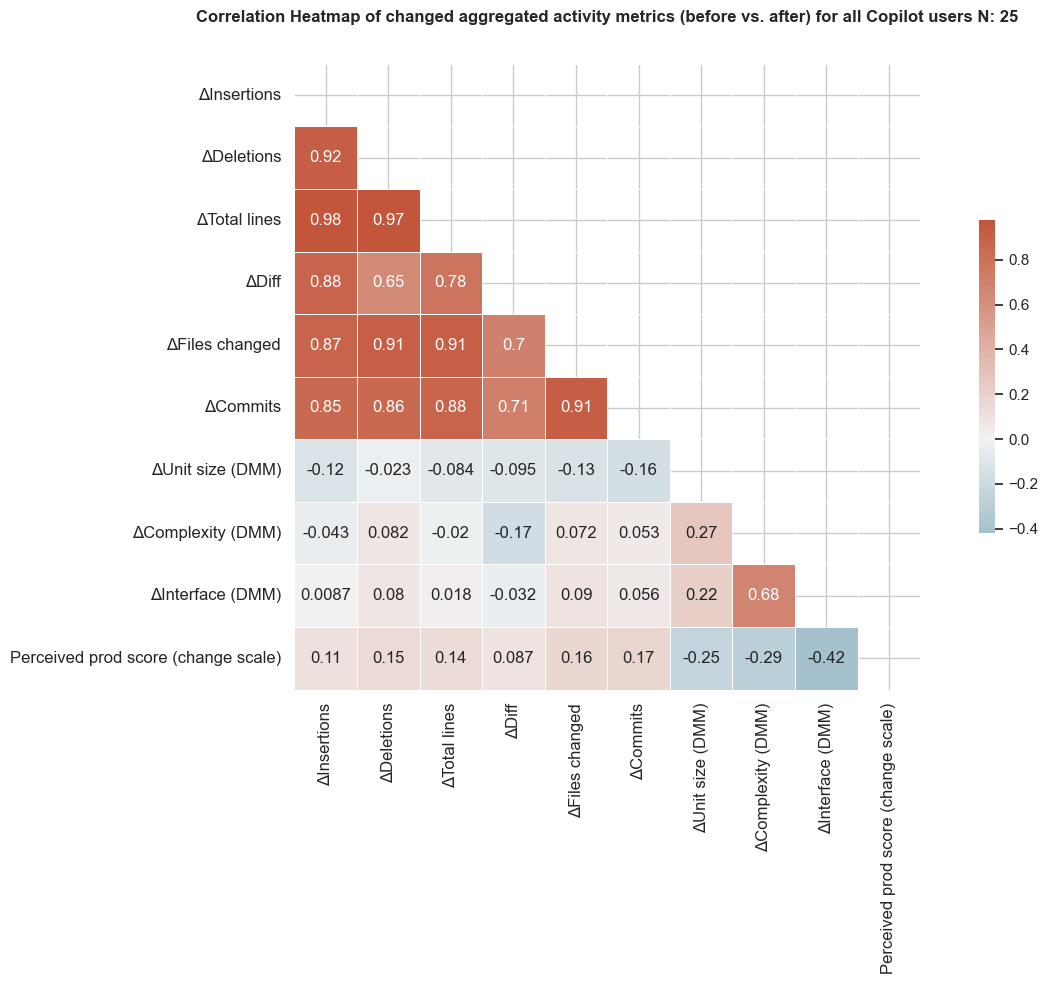

In [297]:
"""
Correlation between variables - copilot users in "before" and "after" period:

Function for creating a heat map showing the correlation between the aggregated 
activity metrics from the commit data and data from survey - percieved productivity and 
aggregated productivity (from the scale). 

Args:
    df (pandas dataframe): dataframe of commit data that is cleaned
"""

# Order of cols in our heatmap
ordered_cols = ["ΔInsertions", "ΔDeletions", "ΔTotal lines", "ΔDiff", "ΔFiles changed", "ΔCommits",  
                "ΔUnit size (DMM)", "ΔComplexity (DMM)", "ΔInterface (DMM)", 
                "Perceived prod score (change scale)"]

# Compute correlation matrix in defined order
corr_matrix = df_survey_diff_long[ordered_cols].corr(method="spearman")

# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

users = df_survey_diff_long["User"].unique().tolist()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap=cmap,
    #vmax=0.3,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": 0.5},
)

plt.xticks(size=12)
plt.yticks(size=12)
# g.set_ylabels("Average weekly activity", size=16)
# g.set_titles(col_template="{col_name}", size=18)
plt.title(f"Correlation Heatmap of changed aggregated activity metrics (before vs. after) for all Copilot users N: {len(users)}", weight="bold", pad=30)
plt.tight_layout()
file_name = "heatmap_change.pdf"
full_path = os.path.join(plots_parent_dir, file_name)
plt.savefig(full_path, format="pdf", pad_inches=0.1)
plt.show()
plt.close()

## Scatter plots of aggregated activity metrics and the percieved productivity of Copilot users

- We now try to visualize the correlations between the change in activity metrics and the percieved change in productivity 
- This is done with scatter plots and a trendline

In [298]:
from scipy.stats import spearmanr

# Directory for lineplots
parent_dir = plots_parent_dir
scatter_plots_sub_dir = "scatter_plots"
scatter_plots_path = os.path.join(parent_dir, scatter_plots_sub_dir)
os.makedirs(scatter_plots_path, exist_ok=True)

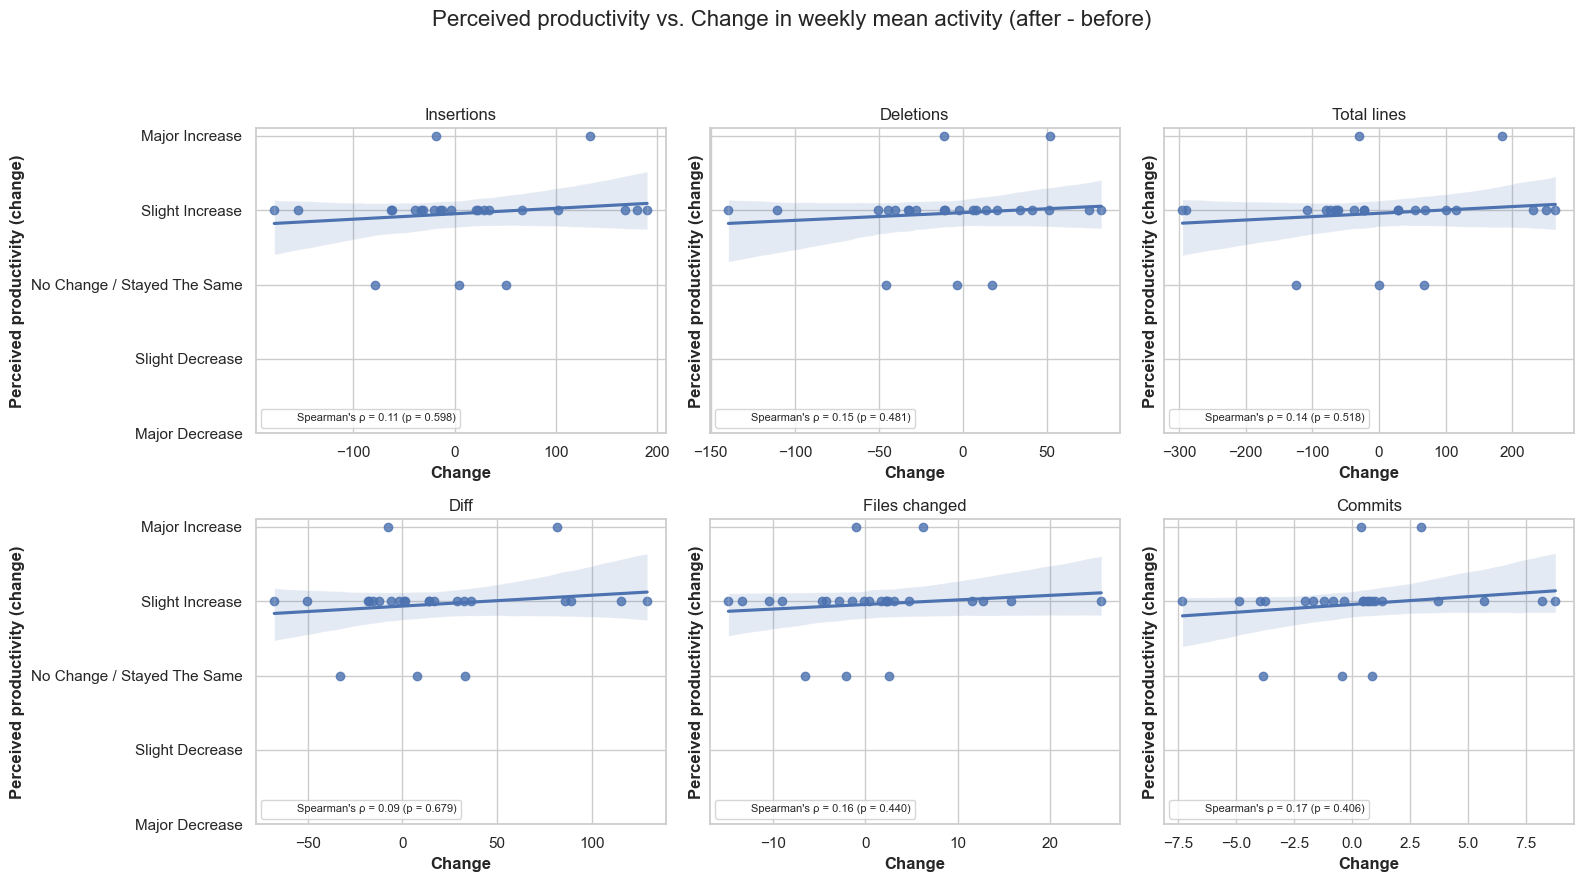

In [299]:
metrics = ["Insertions", "Deletions", "Total lines", "Diff", "Files changed", "Commits"]

df_temp = df_survey_diff_long.copy()

fig, axes = plt.subplots(nrows=2, ncols=(len(metrics) + 1) // 2, figsize=(16, 8), sharey=True)
axes = axes.flatten()

for i, metric in enumerate(metrics):
    df_temp = df_survey_diff_long.copy()
    
    diff_col = f"Δ{metric}"
    
    x = diff_col
    y = "Perceived prod score (change scale)" #"Perceived score"
    
    # Get spearman"s coefficent (rho) which looks for montonic relationship between x and y variables
    spearman_rho, spearman_p = spearmanr(df_temp[x], df_temp[y])

    # Plot
    ax = axes[i]
    sns.regplot(
        data=df_temp, 
        x=diff_col, 
        y="Perceived prod score (change scale)", 
        ax=ax,
        )
    
    ax.set_title(metric)
    #ax.set_xlim(-max_abs, max_abs)    
    label_text = f"Spearman's ρ = {spearman_rho:.2f} (p = {spearman_p:.3f})"
    ax.plot([], [], " ", label=label_text)
    ax.legend(loc="lower left", fontsize=8)
    ax.set_xlabel("Change", weight="bold")
    ax.set_ylabel("Perceived productivity (change)", weight="bold")

plt.yticks(ticks=[1, 2, 3, 4, 5], labels=["Major Decrease", "Slight Decrease",  "No Change / Stayed The Same", "Slight Increase", "Major Increase"]) #labels=["Major Increase", "Slight Increase", "No Change / Stayed The Same", "Slight Decrease", "Major Decrease"])
plt.tight_layout()
plt.suptitle("Perceived productivity vs. Change in weekly mean activity (after - before)", fontsize=16, y=1.1)

file_name = "scatterplot.pdf"
full_path = os.path.join(plots_parent_dir, file_name)
plt.savefig(full_path, format="pdf")
plt.show()
plt.close()

### Save sepeate figs for scatter plots

In [300]:
metrics = ["Insertions", "Deletions", "Total lines", "Diff", "Files changed", "Commits"]

# For each metric - calculate the weekly mean of activity in the before and after period - then calculate the difference 
for metric in metrics:
    df_temp = df_survey_diff_long.copy()

    diff_col = f"Δ{metric}"
    
    x = diff_col
    y = "Perceived prod score (change scale)" 
    
    # Get pearson"s coefficent (r) which looks for linear relationship between x and y variables
    #pearson_r, pearson_p = pearsonr(df_temp[x], df_temp[y])
    
    # Get spearman"s coefficent (rho) which looks for montonic relationship between x and y variables
    spearman_rho, spearman_p = spearmanr(df_temp[x], df_temp[y])

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.regplot(
        data=df_temp, 
        x=diff_col, 
        y="Perceived prod score (change scale)", 
        ax=ax,
        )
    
    ax.set_title(metric, fontsize=15)
    #ax.set_xlim(-max_abs, max_abs)    
    label_text = f"Spearman's ρ = {spearman_rho:.2f} (p = {spearman_p:.3f})"
    ax.plot([], [], " ", label=label_text)
    ax.legend(loc="lower left", fontsize=15)
    ax.set_xlabel(f"Change in average weekly {metric}", weight="bold")
    ax.set_ylabel("Perceived productivity (change)", weight="bold")

    plt.yticks(ticks=[1, 2, 3, 4, 5], labels=["Major Decrease", "Slight Decrease",  "No Change / Stayed The Same", "Slight Increase", "Major Increase"]) #labels=["Major Increase", "Slight Increase", "No Change / Stayed The Same", "Slight Decrease", "Major Decrease"])
    fig.suptitle("Perceived productivity vs. Change in average weekly activity (after - before)\n(Copilot users only, n=25)", fontsize=15, weight="bold")
    fig.tight_layout(rect=[0, 0, 1, 0.92], pad=2)

    file_name = f"{metric}_scatter_plot.pdf"
    full_path = os.path.join(scatter_plots_path, file_name)
    plt.savefig(full_path, format="pdf",  bbox_inches="tight")
    plt.close()